In [1]:
import os
import sys

import numpy as np
import cv2
from sklearn import linear_model

import lane_finding as lane

import lane_double_ransac as dlransac
from lane_double_ransac import DLanesRANSACRegressor

import lane_simple_ransac as slransac
from lane_simple_ransac import SLanesRANSACRegressor


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Camera calibration

Computation of the calibration parameters, and example proving we obtain the expected result.

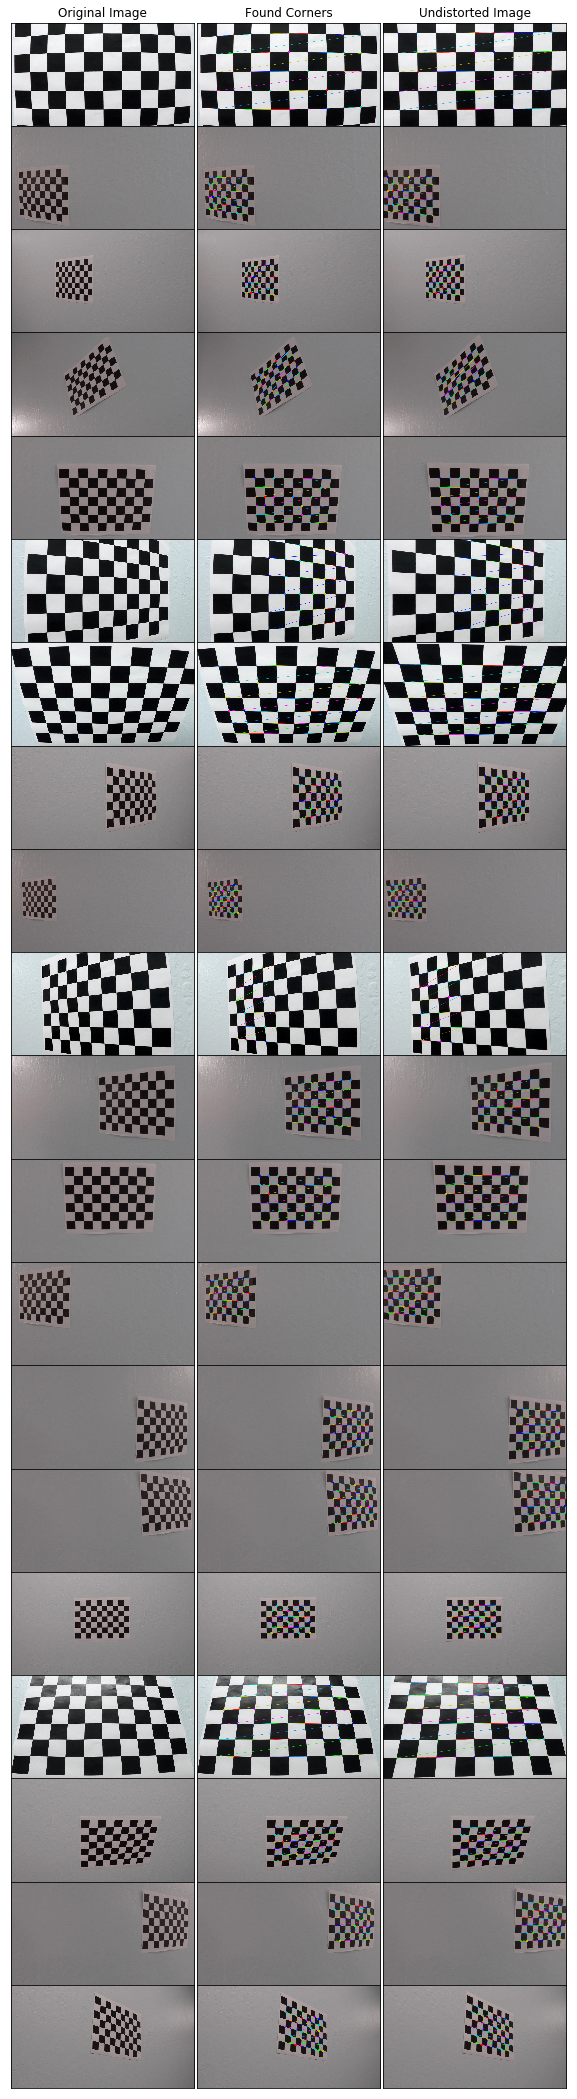

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import re
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# The images may have different detected checker board dimensions!
# Currently, possible dimension combinations are: (9,6), (8,6), (9,5), (9,4) and (7,6)
objp1 = np.zeros((6*9,3), np.float32)
objp1[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
objp2 = np.zeros((6*8,3), np.float32)
objp2[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)
objp3 = np.zeros((5*9,3), np.float32)
objp3[:,:2] = np.mgrid[0:9, 0:5].T.reshape(-1,2)
objp4 = np.zeros((4*9,3), np.float32)
objp4[:,:2] = np.mgrid[0:9, 0:4].T.reshape(-1,2)
objp5 = np.zeros((6*7,3), np.float32)
objp5[:,:2] = np.mgrid[0:7, 0:6].T.reshape(-1,2)
objp6 = np.zeros((6*5,3), np.float32)
objp6[:,:2] = np.mgrid[0:5, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Setup plot
fig = plt.figure(figsize=(10, len(images)*1.9))
w_ratios = [1 for n in range(3)]
h_ratios = [1 for n in range(len(images))]
grid = gridspec.GridSpec(len(images), 3, wspace=0.0, hspace=0.0, width_ratios=w_ratios, height_ratios=h_ratios)
i = 0

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img2 = np.copy(img)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners using possible combinations of dimensions.
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    objp = objp1
    if not ret:
        ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
        objp = objp2
    if not ret:
        ret, corners = cv2.findChessboardCorners(gray, (9,5), None)
        objp = objp3
    if not ret:
        ret, corners = cv2.findChessboardCorners(gray, (9,4), None)
        objp = objp4
    if not ret:
        ret, corners = cv2.findChessboardCorners(gray, (7,6), None)
        objp = objp5
    if not ret:
        ret, corners = cv2.findChessboardCorners(gray, (5,6), None)
        objp = objp6
    # print("corners: ", corners.shape, "\n", corners)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img2, (corners.shape[1],corners.shape[0]), corners, ret)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        img3 = cv2.undistort(img2, mtx, dist, None, mtx)

        # next image
        ax = plt.Subplot(fig, grid[i])
        ax.imshow(img)
        if i==0:
            ax.set_title('Original Image')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 1
        ax = plt.Subplot(fig, grid[i])
        ax.imshow(img2)
        if i==1:
            ax.set_title('Found Corners')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 1
        ax = plt.Subplot(fig, grid[i])
        ax.imshow(img3)
        if i==2:
            ax.set_title('Undistorted Image')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 1

    else:
        # next image
        ax = plt.Subplot(fig, grid[i])
        ax.set_title('Corners Not Found! %s'%(fname))
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        i += 3
        
plt.show()

## Perspective transform

Compute the perspective transform matrix using a sample image (in `perspective` directory). The source and destination points are stored in the json file `perspective.json`. Below is shown the result of the transform on the image used for determining the parameters.

In [14]:
import json

def load_points(filename, key, dtype=np.float32):
    with open(filename) as fdata:
        jdata = json.load(fdata)
    data = np.array(jdata.get(key, []), dtype=dtype)
    return data

def perspective_transform(src_points, dst_points):
    mtx_perp = cv2.getPerspectiveTransform(src_points, dst_points)
    mtx_perp_inv = cv2.getPerspectiveTransform(dst_points, src_points)
    return mtx_perp, mtx_perp_inv

def test_perspective(img, src_points, mtx_perp):
    l = len(src_points)
    lines = [[[src_points[i][0],
               src_points[i][1],
               src_points[(i+1) % l][0],
               src_points[(i+1) % l][1]]] for i in range(l)]
    draw_lines(img, lines, thickness=2)

    wimg = warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)

    plot_dual(img, wimg,
              title1='Original image.',
              title2='Warped image.', figsize=(24, 9))
    
def load_image(filename, crop_shape=(720, 1280)):
    img = mpimg.imread(filename)
    shape = img.shape
    if shape[0] > crop_shape[0]:
        img = img[-crop_shape[0]:, :, :]
    if shape[1] > crop_shape[1]:
        img = img[:, :crop_shape[1], :]
    return img

Source points:
 [[  240.   720.]
 [  575.   460.]
 [  715.   460.]
 [ 1150.   720.]]
Destination points:
 [[ 440.  720.]
 [ 440.    0.]
 [ 950.    0.]
 [ 950.  720.]]
Perspective scaling: [ 0.042  0.006]


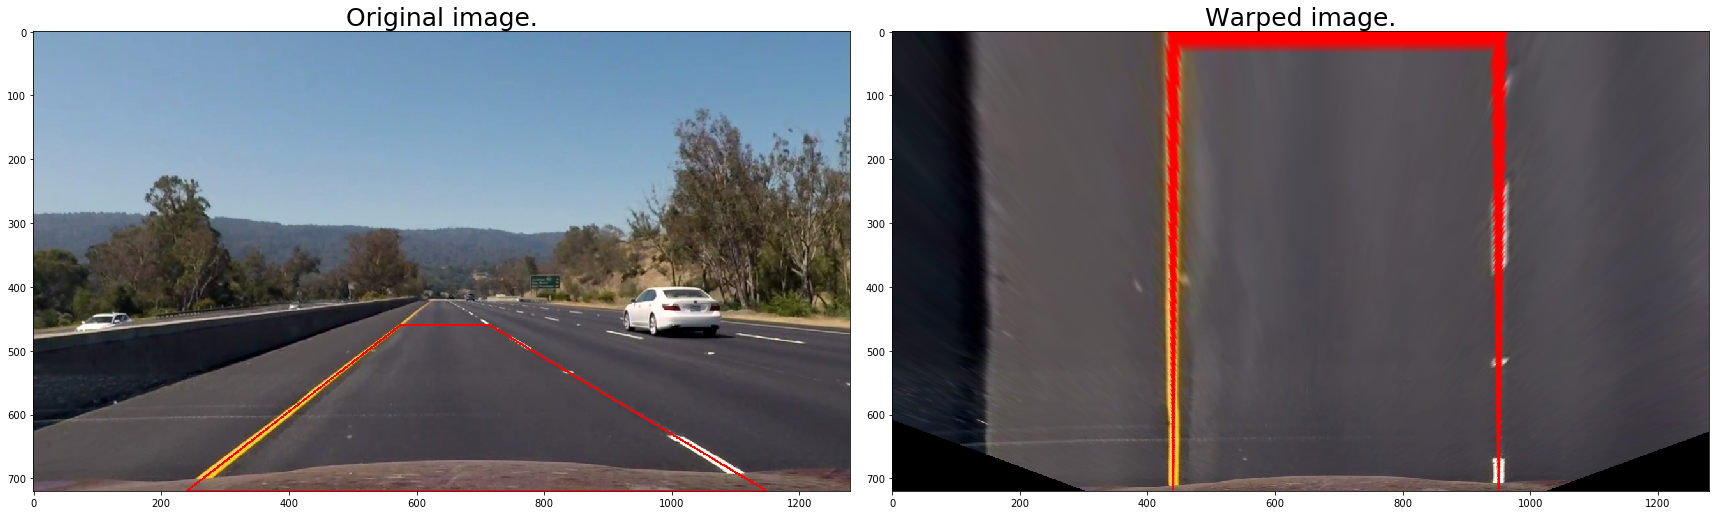

In [15]:
# Determine perspective transform.
fname = 'perspective/perspective.json'
src_points = load_points(fname, 'src', dtype=np.float32)
dst_points = load_points(fname, 'dst', dtype=np.float32)
perp_scaling = load_points(fname, 'scaling', dtype=np.float32)
mtx_perp, mtx_perp_inv = perspective_transform(src_points, dst_points)
print('Source points:\n', src_points)
print('Destination points:\n', dst_points)
print('Perspective scaling:', perp_scaling)

# Test the perspective transform.
fname = 'perspective/perspective.jpg'
img = lane.undistort_image(load_image(fname), mtx, dist)
lane.test_perspective(img, src_points, mtx_perp)

## Main pipeline

The computation of the lanes is divided in several steps:
* computing masks containing the lanes, using Grayscale and HSL color images;
* fitting two lanes using masks information: we use for that purpose the well-known RANSAC regression, adapted to this setting.

In [23]:
path = 'test_images/'
filenames = os.listdir(path)

def undistort_image(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, mtx_perp, img_size, flags=cv2.INTER_LINEAR)

def plot_images(imgs, titles, cmap='gray', figsize=(24, 9)):
    nimgs = len(imgs)
    f, axes = plt.subplots(1, nimgs, figsize=figsize)
    f.tight_layout()
    for i in range(nimgs):
        axes[i].imshow(imgs[i], cmap=cmap)
        axes[i].set_title(titles[i], fontsize=25)

TEST on image: test_images/test17.jpg (720, 1280, 3)


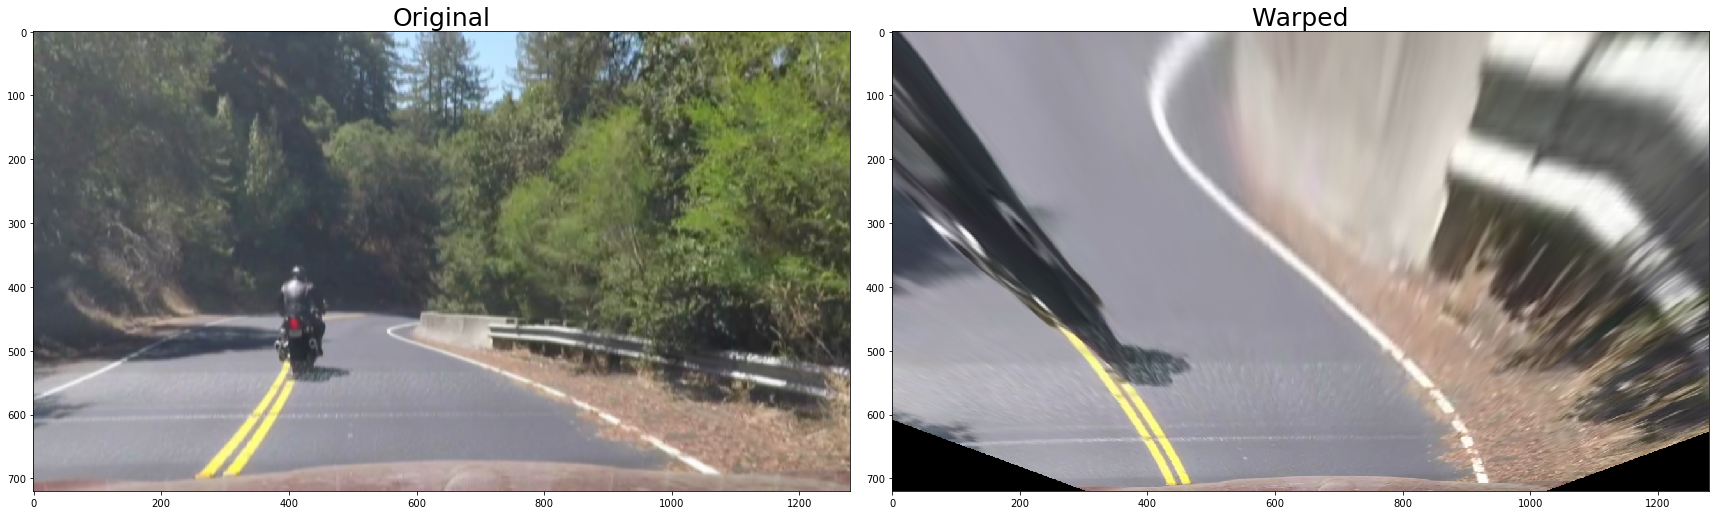

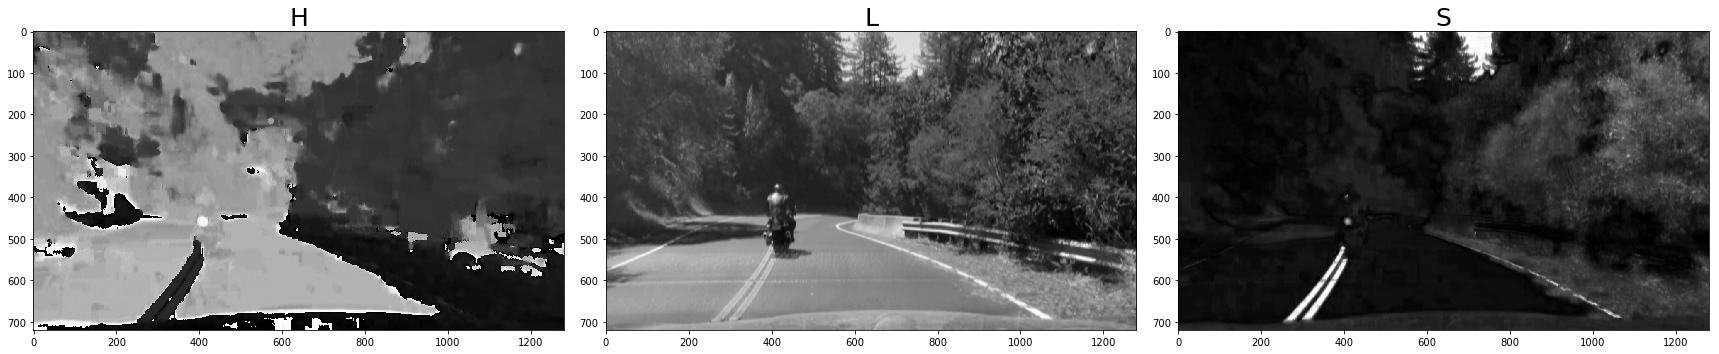

In [24]:
fname = path + os.listdir(path)[20]
img = undistort_image(load_image(fname), mtx, dist)

wimg = warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)
print('TEST on image:', fname, img.shape)
img = cv2.GaussianBlur(img, (1, 11), 0)

img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

plot_images((img, wimg), ('Original', 'Warped'), figsize=(24, 9))
plot_images((img_hsl[:, : , 0], img_hsl[:, : , 1], img_hsl[:, : , 2]), ('H', 'L', 'S'), figsize=(24, 9))

### Masks from Grayscale and HSL images

In [36]:
def gradient_x(gray, sobel_kernel=3):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    gradmag = sobelx
    scale_factor = np.max(gradmag) / 255.
    gradmag = (gradmag / scale_factor)
    return gradmag


def gradient_y(gray, sobel_kernel=3):
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = sobely
    scale_factor = np.max(gradmag) / 255.
    gradmag = (gradmag / scale_factor)
    return gradmag

def warped_masks_original(img, m_perp, thresholds=[20, 25]):
    wmasks = []
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    gammas = [1.]
    for g in gammas:
        skernel = 13
        sobel_dx = gradient_x(gray, sobel_kernel=skernel)
        s_sobel_dx = gradient_x(hsl[:, :, 2], sobel_kernel=skernel)

        wsobel_dx = warp_image(sobel_dx, m_perp, flags=cv2.INTER_LANCZOS4)
        ws_sobel_dx = warp_image(s_sobel_dx, m_perp, flags=cv2.INTER_LANCZOS4)

        mask = mask_local_crossing_x(wsobel_dx, threshold=thresholds[0],
                                     dilate_kernel=(2, 8), iterations=3)
        wmasks.append(mask)
        mask = mask_local_crossing_x(ws_sobel_dx, threshold=thresholds[1],
                                     dilate_kernel=(2, 8), iterations=3)
        wmasks.append(mask)
        
    return wmasks

def mask_local_crossing_x(gray, threshold=20, dilate_kernel=(2, 6), iterations=3):
    # Increasing mask.
    mask_neg = (gray < -threshold).astype(np.float32)
    mask_pos = (gray > threshold).astype(np.float32)

    mid = dilate_kernel[1] // 2

    kernel = np.ones(dilate_kernel, np.uint8)
    kernel[:, 0:mid] = 0
    dmask_neg = cv2.dilate(mask_neg, kernel, iterations=iterations) > 0.

    kernel = np.ones(dilate_kernel, np.uint8)
    kernel[:, mid:] = 0
    dmask_pos = cv2.dilate(mask_pos, kernel, iterations=iterations) > 0.
    dmask = (dmask_pos * dmask_neg).astype(np.uint8)

    return dmask

def default_left_right_masks(img, margin=0.1):
    shape = img.shape[0:2]
    llimit = int(shape[1] / 2 + shape[1] * margin)
    rlimit = int(shape[1] / 2 - shape[1] * margin)

    xv, yv = np.mgrid[0:shape[0], 0:shape[1]]
    lmask = yv <= llimit
    rmask = yv >= rlimit

    return lmask, rmask

def draw_mask(img, mask, color=[255, 0, 0], alpha=0.8, beta=1., gamma=0.):
    mask = (mask > 0).astype(np.uint8)
    color_mask = np.dstack((color[0] * mask, color[1] * mask, color[2] * mask))
    return cv2.addWeighted(img, alpha, color_mask, beta, gamma)

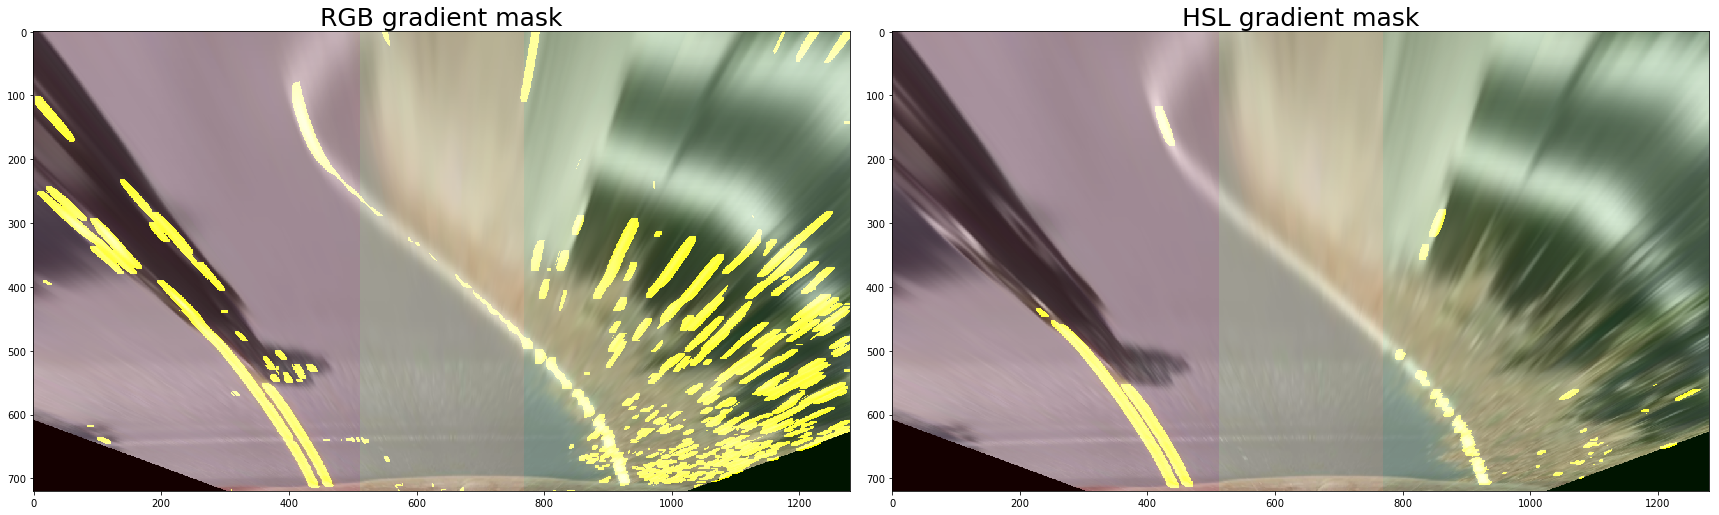

In [37]:
# Compute warped masks...
wimg = warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
wmasks = warped_masks_original(img, mtx_perp, thresholds=[20, 20])
lmask, rmask = default_left_right_masks(img, margin=0.1)

wimgs = []
titles = ['RGB gradient mask', 'HSL gradient mask']
for i, wm in enumerate(wmasks):
    mimg = draw_mask(wimg, lmask, alpha=.9, beta=1., gamma=0., color=[20, 0, 0])
    mimg = draw_mask(mimg, rmask, alpha=1, beta=1., gamma=0., color=[0, 20, 0])
    mimg = draw_mask(mimg, wm, alpha=1, beta=1., gamma=0., color=[255, 255, 0])
    wimgs.append(mimg)

for i in range(len(wimgs) // 2):
    plot_images(wimgs[2*i:2*i+2], titles[2*i:2*i+2], figsize=(24, 9))

### RANSAC regression using the former masks

In [64]:
import copy
import numba

from sklearn.base import BaseEstimator, MetaEstimatorMixin, RegressorMixin, clone
from sklearn.utils import check_random_state, check_array, check_consistent_length
from sklearn.utils.random import sample_without_replacement
from sklearn.utils.validation import check_is_fitted
from sklearn.linear_model.base import LinearRegression
from sklearn.utils.validation import has_fit_parameter

_EPSILON = np.spacing(1)

def masks_to_points(wmasks, add_mask, order=2, reverse_x=True, normalise=True, dtype=np.float32):
    shape = add_mask.shape
    x = np.zeros((0,))
    y = np.zeros((0,))
    for wm in wmasks:
        # Left points.
        x0, y0 = np.where(wm * add_mask)
        x = np.append(x, x0)
        y = np.append(y, y0)

    if reverse_x:
        x = shape[0] - x - 1
    if normalise:
        x = x.astype(dtype) / shape[0]
        y = y.astype(dtype) / shape[1] - 0.5

    # Construct big vector! Assume order-2 model.
    X = np.zeros((len(x), order+1), dtype=dtype)
    X[:, 0] = 1.
    for i in range(1, order+1):
        X[:, i] = x**i
    return X.astype(dtype), y.astype(dtype)

In [69]:
@numba.jit(nopython=True, nogil=True)
def inverse_3x3(m):
    """Inverse 3x3 matrix. Manual implementation!

    Very basic benchmarks show it's ~3x faster than calling numpy inverse
    method. Nevertheless, I imagine that much better optimised version exist
    in the MKL or other library (using SIMD, AVX, and so on).
    I have no idea how far Numba+LLVM is able to go in terms of optimisation of
    this code.
    """
    mflat = m.reshape((m.size, ))
    minv = np.zeros_like(mflat)

    minv[0] = mflat[4] * mflat[8] - mflat[5] * mflat[7]
    minv[3] = -mflat[3] * mflat[8] + mflat[5] * mflat[6]
    minv[6] = mflat[3] * mflat[7] - mflat[4] * mflat[6]

    minv[1] = -mflat[1] * mflat[8] + mflat[2] * mflat[7]
    minv[4] = mflat[0] * mflat[8] - mflat[2] * mflat[6]
    minv[7] = -mflat[0] * mflat[7] + mflat[1] * mflat[6]

    minv[2] = mflat[1] * mflat[5] - mflat[2] * mflat[4]
    minv[5] = -mflat[0] * mflat[5] + mflat[2] * mflat[3]
    minv[8] = mflat[0] * mflat[4] - mflat[1] * mflat[3]

    det = mflat[0] * minv[0] + mflat[1] * minv[3] + mflat[2] * minv[6]
    # UGGGGGLLLLLLLLYYYYYYYYYY!
    if np.abs(det) <= _EPSILON:
        det = 1e-10

    det = 1.0 / det
    for i in range(9):
        minv[i] = minv[i] * det
    minv = minv.reshape((3, 3))
    return minv

@numba.jit(nopython=True, nogil=True)
def inverse_3x3_symmetric(m):
    """Inverse 3x3 symmetric matrix. Manual implementation!
    """
    mflat = m.reshape((m.size, ))
    minv = np.zeros_like(mflat)

    minv[0] = mflat[4] * mflat[8] - mflat[5] * mflat[7]
    minv[3] = -mflat[3] * mflat[8] + mflat[5] * mflat[6]
    minv[6] = mflat[3] * mflat[7] - mflat[4] * mflat[6]

    minv[1] = minv[3]
    minv[4] = mflat[0] * mflat[8] - mflat[2] * mflat[6]
    minv[7] = -mflat[0] * mflat[7] + mflat[1] * mflat[6]

    minv[2] = minv[6]
    minv[5] = minv[7]
    minv[8] = mflat[0] * mflat[4] - mflat[1] * mflat[3]

    det = mflat[0] * minv[0] + mflat[1] * minv[3] + mflat[2] * minv[6]
    # UGGGGGLLLLLLLLYYYYYYYYYY!
    if np.abs(det) <= _EPSILON:
        det = 1e-10

    det = 1.0 / det
    for i in range(9):
        minv[i] = minv[i] * det
    minv = minv.reshape((3, 3))
    return minv

@numba.jit(nopython=True, nogil=True)
def numpy_sign(x):
    if x >= 0:
        return 1
    else:
        return -1

@numba.jit(nopython=True, nogil=True)
def is_model_valid(w, wrefs, bounds):
    """Check if a regression diffs model is valid, based on the coefficients.
    Use references coefficients to check w is inside valid bounds.
    Make two
    different types of checking: difference between left and right lanes AND
    individual bounds for every lanes.

    For bounds parameters: here is the second to last index meaning:
      0: Distance between origin points;
      1: Angle at the origin (in radian);
      2: Curvature (compute the relative difference between them);

    Params:
      w: Coefficient of the fit;
      wrefs: Array of reference coefficients;
      bounds: Array of bounds.
    Return
      Is it valid?
    """
    res = True
    n_refs = wrefs.shape[0]
    for i in range(n_refs):
        wref = wrefs[i]
        diffs = bounds[i]

        # Distance at the origin.
        dist = w[0] - wref[0]
        res = np.abs(dist) >= diffs[0, 0]
        res = res and np.abs(dist) <= diffs[0, 1]

        # Angle at the origin.
        theta = np.arcsin(w[1]) - np.arcsin(wref[1])
        res = res and np.abs(theta) >= diffs[1, 0]
        res = res and np.abs(theta) <= diffs[1, 1]

        # Relative curvature.
        a1b2 = np.abs(wref[2]) * (1 + w[1]**2)**1.5
        a2b1 = np.abs(w[2]) * (1 + wref[1]**2)**1.5
        s = a1b2 + a2b1
        if s > _EPSILON:
            rel_curv = (a1b2*numpy_sign(w[2]) - a2b1*numpy_sign(wref[2]) + 2*dist*np.abs(w[2]*wref[2])) / s
            res = res and np.abs(rel_curv) >= diffs[2, 0]
            res = res and np.abs(rel_curv) <= diffs[2, 1]
    return res

@numba.jit(nopython=True, nogil=True)
def lanes_ransac_prefit(X, y,
                        n_prefits, max_trials,
                        w_refs, is_valid_bounds):
    """Construct some pre-fits for Ransac regression.

    Namely: select randomly 4 points, fit a 2nd order curve and then check the
    validity of the fit. Stop when n_prefits have been found or max_trials done.
    Note: aim to be much more efficient and faster than standard RANSAC.
    Could be easily run in parallel on a GPU.

    Params:
      X and y: Points to fit;
      n_prefits: Number of pre-fits to generate;
      max_trials: Maximum number of trials. No infinity loop!
      w_refs: Coefficients used for checking validity.
      is_valid_bounds: Bounds used for checking validity.
    """
    min_prefits = 0
    is_valid_check = w_refs.size == 0

    shape = X.shape
    w_prefits = np.zeros((n_prefits, 3), dtype=X.dtype)

    i = 0
    j = 0
    it = 0
    idxes = np.arange(shape[0])

    # Add w references to prefits.
    # i += 1
    # n_refs = w_refs.shape[0]
    # for k in range(n_refs):
    #     w_prefits[i] = w_refs[k]
    #     i += 1

    # Initial shuffling of points.
    # Note: shuffling should be more efficient than random picking.
    # Processor cache is used much more efficiently this way.
    np.random.shuffle(idxes)
    X = X[idxes]
    y = y[idxes]
    
    # Fill the pre-fit arrays...
    while i < n_prefits and (it < max_trials or i < min_prefits):
        # Sub-sampling 4 points.
        _X = X[j:j+4]
        _y = y[j:j+4]
        # Solve linear regression! Hard job :)
        _XT = _X.T
        w = inverse_3x3_symmetric(_XT @ _X) @ _XT @ _y
        # Is model basically valid? Then save it!
        if is_valid_check or is_model_valid(w, w_refs, is_valid_bounds):
            w_prefits[i] = w
            i += 1
        j += 1
        it += 1

        # Get to the end: reshuffle another time!
        if j == shape[0]-3:
            np.random.shuffle(idxes)
            X = X[idxes]
            y = y[idxes]
            j = 0
    # Resize if necessary.
    if i < n_prefits:
        w_prefits = w_prefits[:i]
    return w_prefits

def test_lanes_ransac_prefit(n_prefits=1000):
    """Basic test of the lanes RANSAC pre-fit.
    """
    n = n_prefits
    X = np.random.rand(n, 3)
    y = np.random.rand(n)
    w_refs = np.ones((1, 3), dtype=X.dtype)
    valid_bounds = np.ones((1, 3, 2), dtype=X.dtype)
    lanes_ransac_prefit(X, y, n_prefits, n_prefits, w_refs, valid_bounds)

@numba.jit(nopython=True, nogil=True)
def lane_translate(w, delta):
    """Translate a lane coefficient while keeping same curvature center.
    """
    w1 = np.copy(w)
    w1[0] = delta + w[0]
    w1[1] = w[1]
    w1[2] = w[2] * (1 + w[1]**2)**1.5 / ((1 + w[1]**2)**1.5 - 2*delta*w[2])
    return w1

@numba.jit(nopython=True, nogil=True)
def m_regression_exp(X, y, w0, scales):
    """M-estimator used to regularise predictions. Use exponential weights.
    Iterates over an array of scales.
    """
    w = np.copy(w0)
    XX = np.copy(X)
    yy = np.copy(y)
    weights = np.zeros_like(y)
    for s in scales:
        y_pred = X @ w
        weights = np.exp(-np.abs(y - y_pred)**2 / s**2)
        XX[:, 0] = X[:, 0] * weights
        XX[:, 1] = X[:, 1] * weights
        XX[:, 2] = X[:, 2] * weights
        XXT = XX.T
        yy = y * weights
        w = np.linalg.inv(XXT @ XX) @ XXT @ yy
    return w

@numba.jit(nopython=True, nogil=True)
def linear_regression_fit(X, y):
    """Linear Regression: fit X and y.
    Very basic implementation based on inversing X.T @ X. Enough in low
    dimensions.
    """
    XT = X.T
    w = np.linalg.inv(XT @ X) @ XT @ y
    return w

@numba.jit(nopython=True, nogil=True)
def linear_regression_predict(X, w):
    """Linear Regression: predicted y from X and w.
    """
    y_pred = X @ w
    return y_pred

@numba.jit(nopython=True, nogil=True)
def linear_regression_score(X, y, w, mask):
    """Linear Regression: score in interval [0,1]. Compute L2 norm and y
    variance to obtain the score.
    """
    y_pred = X @ w
    u = np.sum((y - y_pred)**2 * mask)
    v = np.sum((y - np.mean(y))**2 * mask)
    if v > _EPSILON:
        score = 1 - u / v
    else:
        score = -np.inf
    return score

@numba.jit(nopython=True, nogil=True)
def lanes_inliers(X, y, w, residual_threshold):
    """Compute the RANSAC inliers mask, based on a given threshold and
    regression coefficients.
    """
    y_pred = X @ w
    residuals_subset = np.abs(y - y_pred)
    inlier_mask_subset = residuals_subset < residual_threshold
    return inlier_mask_subset

@numba.jit(nopython=True, nogil=True)
def lane_score(n_inliers, w, wrefs, lambdas):
    score = lambdas[0] * n_inliers
    if wrefs.size > 0:
        wref = wrefs[0]
        score += np.exp(-(w[0] - wref[0])**2 / lambdas[1]**2)
        score += np.exp(-(w[1] - wref[1])**2 / lambdas[2]**2)
        score += np.exp(-(w[2] - wref[2])**2 / lambdas[3]**2)
    return score

@numba.jit(nopython=True, nogil=True)
def ransac_absolute_loss(y_true, y_pred):
    """Absolute loss!
    """
    return np.abs(y_true - y_pred)

@numba.jit(nopython=True, nogil=True)
def lanes_ransac_select_best(X, y, w_prefits, residual_threshold, wrefs, lambdas):
    """Select best pre-fit from a collection. Score them using the number
    of inliers: keep the one cumulating the highest number.
    """
    n_prefits = w_prefits.shape[0]
    n_points = np.float32(y.size)

    # Best match variables.
    score_best = -np.inf
    inlier_mask_best = (y == np.inf)
    best_w = w_prefits[0]

    # Number of data samples
    n_samples = X.shape[0]
    sample_idxs = np.arange(n_samples)
    for i in range(n_prefits):
        # Predictions on the dataset.
        w = w_prefits[i]
        y_pred = X @ w

        # Inliers / outliers masks
        residuals_subset = np.abs(y - y_pred)
        # classify data into inliers and outliers
        inlier_mask_subset = residuals_subset < residual_threshold
        n_inliers_subset = np.sum(inlier_mask_subset)

        # Compute score.
        score_subset = lane_score(n_inliers_subset, w, wrefs, lambdas)
        if score_subset > score_best:
            # Save current random sample as best sample
            score_best = score_subset
            inlier_mask_best = inlier_mask_subset
            best_w = w

    return best_w, inlier_mask_best, score_best

class SLanesRANSACRegressor(BaseEstimator, MetaEstimatorMixin, RegressorMixin):
    def __init__(self,
                 residual_threshold=None,
                 n_prefits=1000,
                 max_trials=100,
                 w_refs_left=None,
                 w_refs_right=None,
                 is_valid_bounds_left=None,
                 is_valid_bounds_right=None,
                 l2_scales=None,
                 score_lambdas=None,
                 smoothing=1.,
                 stop_n_inliers=np.inf,
                 stop_score=np.inf,
                 stop_probability=0.99,
                 random_state=None,
                 dtype=np.float32):

        self.residual_threshold = residual_threshold

        self.n_prefits = n_prefits
        self.max_trials = max_trials

        if w_refs_left is None:
            self.w_refs_left = np.zeros((0, 3), dtype=dtype)
            self.is_valid_bounds_left = np.zeros((0, 3, 2), dtype=dtype)
        else:
            self.w_refs_left = w_refs_left
            self.is_valid_bounds_left = is_valid_bounds_left
        if w_refs_right is None:
            self.w_refs_right = np.zeros((0, 3), dtype=np.float32)
            self.is_valid_bounds_right = np.zeros((0, 3, 2), dtype=dtype)
        else:
            self.w_refs_right = w_refs_right
            self.is_valid_bounds_right = is_valid_bounds_right

        self.l2_scales = l2_scales
        self.smoothing = smoothing
        if score_lambdas is None:
            self.score_lambdas = np.ones((4, ), dtype=dtype)
        else:
            self.score_lambdas = score_lambdas

        self.stop_n_inliers = stop_n_inliers
        self.stop_score = stop_score
        self.stop_probability = stop_probability
        self.random_state = random_state
        
    def fit(self, X1, y1, X2, y2, left_right_bounds=None):
        """Fit estimator using RANSAC algorithm.

        Namely, the fit is done into two main steps:
        - pre-fitting: quickly select n_prefits configurations which seems
        suitable given topological constraints.
        - finding best fit: select the pre-fit with the maximum number of inliers
        as the best fit.

        Inputs:
          X1, y1: Left lane points (supposedly)
          X2, y2: Right lane points (supposedly)
        """
        check_consistent_length(X1, y1)
        check_consistent_length(X2, y2)

        # Assume linear model by default
        min_samples = X1.shape[1] + 1
        if min_samples > X1.shape[0] or min_samples > X2.shape[0]:
            raise ValueError("`min_samples` may not be larger than number "
                             "of samples ``X1-2.shape[0]``.")

        # Check additional parameters...
        if self.stop_probability < 0 or self.stop_probability > 1:
            raise ValueError("`stop_probability` must be in range [0, 1].")
        if self.residual_threshold is None:
            residual_threshold = np.median(np.abs(y - np.median(y)))
        else:
            residual_threshold = self.residual_threshold
        delta_left_right = (left_right_bounds[0, 0, 1] + left_right_bounds[0, 0, 0]) / 2.
        # random_state = check_random_state(self.random_state)

        # Set up lambdas for computing score.
        score_lambdas = np.copy(self.score_lambdas)
        score_lambdas[0] = score_lambdas[0] / (y1.size + y2.size)

        # Collections...
        self.w_fits = []
        self.w_fits_l2 = []
        self.inliers_masks = []
        self.n_inliers = []
        self.score_fits = []
        
        # === Left lane, and then, right lane === #
        w_left_prefits = lanes_ransac_prefit(X1, y1,
                                             self.n_prefits,
                                             self.max_trials,
                                             self.w_refs_left,
                                             self.is_valid_bounds_left)
        (w_left1, in_mask_left1, score_left1) = \
            lanes_ransac_select_best(X1, y1,
                                     w_left_prefits, residual_threshold,
                                     self.w_refs_left, score_lambdas)
        n_inliers_left1 = np.sum(in_mask_left1)

        w_refs = np.vstack((self.w_refs_right, np.reshape(w_left1, (1, 3))))
        is_valid_bounds = np.vstack((self.is_valid_bounds_right, left_right_bounds))
        w_right_prefits = lanes_ransac_prefit(X2, y2,
                                              self.n_prefits,
                                              self.max_trials,
                                              w_refs,
                                              is_valid_bounds)
        w0 = lane_translate(w_left1, delta_left_right)
        w_right_prefits = np.vstack((w0, w_right_prefits))

        (w_right1, in_mask_right1, score_right1) = \
            lanes_ransac_select_best(X2, y2,
                                     w_right_prefits, residual_threshold,
                                     self.w_refs_right, score_lambdas)
        n_inliers_right1 = np.sum(in_mask_right1)
        n_inliers1 = n_inliers_right1 + n_inliers_left1

        self.w_fits.append((w_left1, w_right1))
        self.n_inliers.append(n_inliers1)
        self.inliers_masks.append((in_mask_left1, in_mask_right1))
        self.score_fits.append((score_left1, score_right1))
        
        # === Right lane and then left lane === #
        w_right_prefits = lanes_ransac_prefit(X2, y2,
                                              self.n_prefits,
                                              self.max_trials,
                                              self.w_refs_right,
                                              self.is_valid_bounds_right)
        (w_right2, in_mask_right2, score_right2) = \
            lanes_ransac_select_best(X2, y2,
                                     w_right_prefits, residual_threshold,
                                     self.w_refs_right, score_lambdas)
        n_inliers_right2 = np.sum(in_mask_right2)
        w_refs = np.vstack((self.w_refs_left, np.reshape(w_right2, (1, 3))))
        is_valid_bounds = np.vstack((self.is_valid_bounds_left, left_right_bounds))
        w_left_prefits = lanes_ransac_prefit(X1, y1,
                                             self.n_prefits,
                                             self.max_trials,
                                             w_refs,
                                             is_valid_bounds)
        w0 = lane_translate(w_right2, -delta_left_right)
        w_left_prefits = np.vstack((w0, w_left_prefits))

        (w_left2, in_mask_left2, score_left2) = \
            lanes_ransac_select_best(X1, y1,
                                     w_left_prefits, residual_threshold,
                                     self.w_refs_left, score_lambdas)
        n_inliers_left2 = np.sum(in_mask_left2)
        n_inliers2 = n_inliers_right2 + n_inliers_left2

        self.w_fits.append((w_left2, w_right2))
        self.n_inliers.append(n_inliers2)
        self.inliers_masks.append((in_mask_left2, in_mask_right2))
        self.score_fits.append((score_left2, score_right2))

        # === Previous frame??? === #
        if self.w_refs_left.size > 0 and self.w_refs_right.size > 0:
            in_mask_left3 = lanes_inliers(X1, y1, self.w_refs_left[0], residual_threshold)
            in_mask_right3 = lanes_inliers(X2, y2, self.w_refs_right[0], residual_threshold)
            n_inliers3 = np.sum(in_mask_left3) + np.sum(in_mask_right3)
            score_left3 = lane_score(np.sum(in_mask_left3),
                                     self.w_refs_left[0],
                                     self.w_refs_left,
                                     score_lambdas)
            score_right3 = lane_score(np.sum(in_mask_right3),
                                      self.w_refs_right[0],
                                      self.w_refs_right,
                                      score_lambdas)

            self.w_fits.append((self.w_refs_left[0], self.w_refs_right[0]))
            self.n_inliers.append(n_inliers3)
            self.inliers_masks.append((in_mask_left3, in_mask_right3))
            self.score_fits.append((score_left3, score_right3))
            
        # L2 regression regularisation of fits.
        self.w_fits_l2 = copy.deepcopy(self.w_fits)
        if self.l2_scales is not None:
            for i in range(len(self.w_fits)):
                w1, w2 = self.w_fits[i]
                # Some regression: ignored when inversed matrix error.
                try:
                    w_left = m_regression_exp(X1, y1, w1, self.l2_scales)
                except Exception:
                    w_left = w1
                try:
                    w_right = m_regression_exp(X2, y2, w2, self.l2_scales)
                except Exception:
                    w_right = w2

                in_mask_left = lanes_inliers(X1, y1, w_left, residual_threshold)
                in_mask_right = lanes_inliers(X2, y2, w_right, residual_threshold)
                n_inliers = np.sum(in_mask_left) + np.sum(in_mask_right)
                score_left = lane_score(np.sum(in_mask_left),
                                        w_left,
                                        self.w_refs_left,
                                        score_lambdas)
                score_right = lane_score(np.sum(in_mask_right),
                                         w_right,
                                         self.w_refs_right,
                                         score_lambdas)

                self.w_fits_l2[i] = (w_left, w_right)
                self.n_inliers[i] = n_inliers
                self.inliers_masks[i] = (in_mask_left, in_mask_right)
                self.score_fits[i] = (score_left, score_right)

        # Best fit?
        scores = [s1+s2 for (s1, s2) in self.score_fits]
        idx = np.argmax(scores)
        w_left, w_right = self.w_fits_l2[idx]
        in_mask_left, in_mask_right = self.inliers_masks[idx]

        # Smoothing.
        smoothing = self.smoothing
        if self.w_refs_left.size > 0 and self.w_refs_right.size > 0:
            w_left = smoothing * w_left + (1. - smoothing) * self.w_refs_left[0]
            w_right = smoothing * w_right + (1. - smoothing) * self.w_refs_right[0]

        self.w1_ = w_left
        self.w2_ = w_right
        
        # Set regression parameters.
        base_estimator1 = LinearRegression(fit_intercept=False)
        base_estimator1.coef_ = w_left
        base_estimator1.intercept_ = 0.0
        base_estimator2 = LinearRegression(fit_intercept=False)
        base_estimator2.coef_ = w_right
        base_estimator2.intercept_ = 0.0

        # Save final model parameters.
        self.estimator1_ = base_estimator1
        self.estimator2_ = base_estimator2

        self.inlier_mask1_ = in_mask_left
        self.inlier_mask2_ = in_mask_right

        # # Estimate final model using all inliers
        # # base_estimator1.fit(X1_inlier_best, y1_inlier_best)
        # # base_estimator2.fit(X2_inlier_best, y2_inlier_best)

        return self

    def predict(self, X1, X2):
        """Predict`lanes using the estimated model.

        Parameters
          X1, X2.
        Returns
          y1, y2
        """
        return X1 @ self.w1_, X2 @ self.w2_
        # return self.estimator1_.predict(X1), self.estimator2_.predict(X2)

    def score(self, X1, y1, X2, y2):
        return self.estimator1_.score(X1, y1) + self.estimator1_.score(X2, y2)

In [70]:
FLOAT_DTYPES = np.float32

# Warped image and masks
wimg = lane.warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
wmasks = lane.warped_masks_original(img, mtx_perp)
lmask, rmask = lane.default_left_right_masks(img, margin=0.1)

# Masks points.
X1, y1 = lane.masks_to_points(wmasks, lmask, order=2, reverse_x=True, normalise=True)
X2, y2 = lane.masks_to_points(wmasks, rmask, order=2, reverse_x=True, normalise=True)

# Model validation bounds.
left_right_bounds = np.zeros((1, 3, 2), dtype=X1.dtype)
left_right_bounds[0, 0, 0] = 0.25
left_right_bounds[0, 0, 1] = 0.5
left_right_bounds[0, 1, 1] = 0.1
left_right_bounds[0, 2, 1] = 0.1
valid_bounds = np.zeros((0, 3, 2), dtype=X1.dtype)

# Fit regression.
l2_scales = np.array([0.005, 0.005], dtype=X1.dtype)
# l2_scales=None
res_threshold = 0.01
n_prefits = 5000
max_trials = 500000
lanes_ransac = SLanesRANSACRegressor(residual_threshold=res_threshold, 
                                     n_prefits=n_prefits,
                                     max_trials=max_trials,
                                     l2_scales=l2_scales)
lanes_ransac.fit(X1, y1, X2, y2, left_right_bounds)

SLanesRANSACRegressor(dtype=None,
           is_valid_bounds_left=array([], shape=(0, 3, 2), dtype=float32),
           is_valid_bounds_right=array([], shape=(0, 3, 2), dtype=float32),
           l2_scales=array([ 0.005,  0.005], dtype=float32),
           max_trials=500000, n_prefits=5000, random_state=None,
           residual_threshold=0.01,
           score_lambdas=array([ 1.,  1.,  1.,  1.], dtype=float32),
           smoothing=1.0, stop_n_inliers=inf, stop_probability=0.99,
           stop_score=inf,
           w_refs_left=array([], shape=(0, 3), dtype=float32),
           w_refs_right=array([], shape=(0, 3), dtype=float32))

###  Display lanes on perspective images

In [76]:
def predict_lanes(model_lanes, wimg, order=2, reversed_x=True, normalised=True, dtype=np.float32):
    """Predict lanes using regression coefficients.
    """
    shape = wimg.shape
    x = np.arange(0, shape[0]).astype(dtype)
    # Normalise x values.
    if reversed_x:
        x = shape[0] - x - 1
    if normalised:
        x = x / shape[0]

    # Prediction.
    X = np.zeros((len(x), order+1), dtype=dtype)
    X[:, 0] = 1.
    for i in range(1, order+1):
        X[:, i] = x**i
    y1, y2 = model_lanes.predict(X, X)
    # De-normalise!
    if normalised:
        x = (x) * shape[0]
        X = np.vstack((np.ones(shape[0], ), x, x**2)).T
        y1 = (0.5 + y1) * shape[1]
        y2 = (0.5 + y2) * shape[1]
    if reversed_x:
        x = shape[0] - x - 1
        X = np.vstack((np.ones(shape[0], ), x, x**2)).T

    return X, y1, y2

def lanes_to_wmask(wimg, x1, y1, x2, y2):
    """Generate the lane mask using left and right lanes.
    """
    shape = wimg.shape[0:2]

    # Create an image to draw the lines on
    warp_zero = np.zeros(shape, np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([y1, x1]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([y2, x2])))])
    pts = np.hstack((pts_left, pts_right))
    pts = np.array([pts], dtype=np.int64)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, pts, (0, 255, 0))
    return color_warp

In [77]:
X_lane, y1_lane, y2_lane = predict_lanes(lanes_ransac, wimg, reversed_x=True, normalised=True)
x_lane = X_lane[:, 1]

X1, y1 = masks_to_points(wmasks, lmask, order=2, reverse_x=False, normalise=False)
X2, y2 = masks_to_points(wmasks, rmask, order=2, reverse_x=False, normalise=False)
x1 = X1[:, 1]
x2 = X2[:, 1]
lane_wmask = lanes_to_wmask(wimg, x_lane, y1_lane, x_lane, y2_lane)

# Inlier / Outlier masks
inlier_mask1 = lanes_ransac.inlier_mask1_
outlier_mask1 = np.logical_not(inlier_mask1)
inlier_mask2 = lanes_ransac.inlier_mask2_
outlier_mask2 = np.logical_not(inlier_mask2)

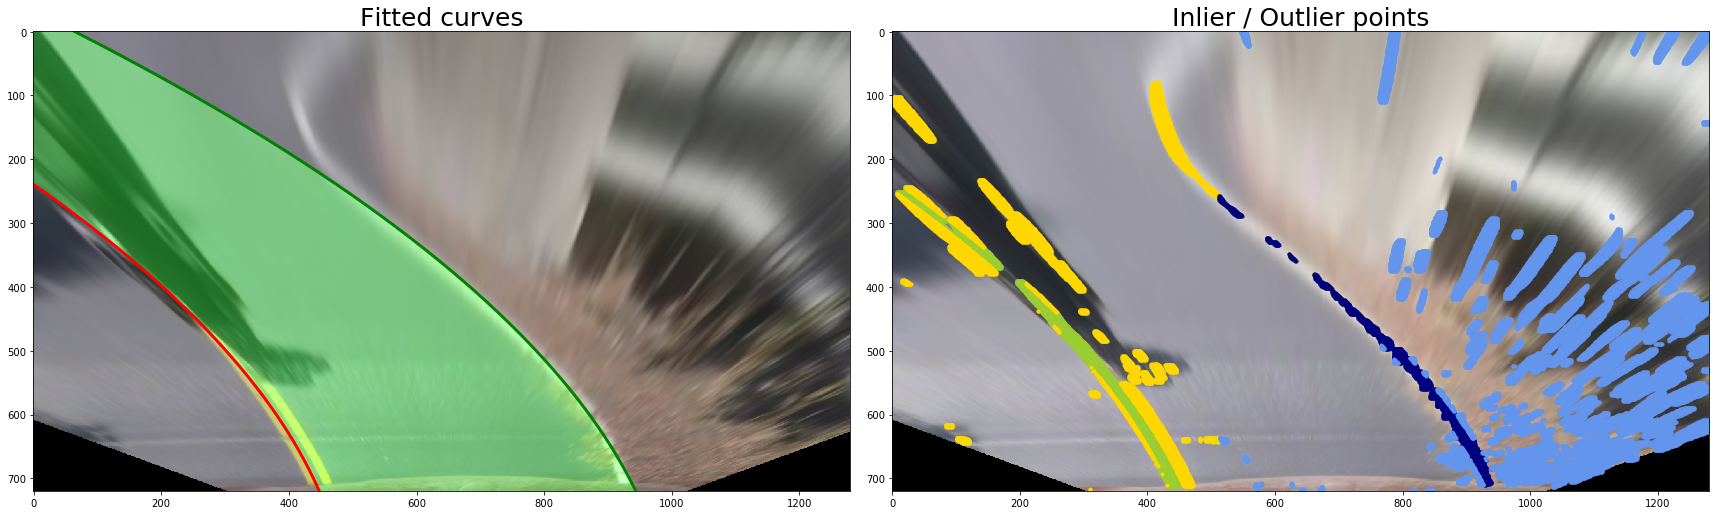

In [78]:
# Plot fitted curves
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot(y1_lane, x_lane,  color='red', linestyle='-', linewidth=3)
ax1.plot(y2_lane, x_lane,  color='green', linestyle='-', linewidth=3)
wm_img = cv2.addWeighted(wimg, 0.8, lane_wmask, 0.3, 0.)
ax1.imshow(wm_img)
ax1.set_title('Fitted curves', fontsize=25)

# Scatter points: inlier and outlier.
plt.scatter(y1[inlier_mask1], x1[inlier_mask1], color='yellowgreen', marker='.')
plt.scatter(y1[outlier_mask1], x1[outlier_mask1], color='gold', marker='.')
plt.scatter(y2[inlier_mask2], x2[inlier_mask2], color='navy', marker='.')
plt.scatter(y2[outlier_mask2], x2[outlier_mask2], color='cornflowerblue', marker='.')
ax2.imshow(wimg)
ax2.set_title('Inlier / Outlier points', fontsize=25)
plt.show()

In [80]:
def lane_curvature(w):
    """Compute curvature from regression coefficients.
    """
    if w[2] != 0.:
        curv = (1 + w[1]**2)**1.5 / (2*w[2])
    else:
        curv = np.inf
    return curv

def rescale_coefficients(wimg, w, scaling, normalised=True):
    """Rescale regression coefficient using a given scaling.
    """
    shape = wimg.shape
    if normalised:
        scaling = [scaling[0] * shape[0], scaling[1] * shape[1]]
    # Re-scale coefficients.
    w_scaled = np.copy(w)
    w_scaled[0] = w[0] * scaling[1]
    w_scaled[1] = w[1] * scaling[1] / scaling[0]
    w_scaled[2] = w[2] * scaling[1] / scaling[0]**2
    return w_scaled

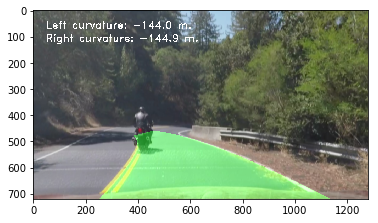

In [81]:
# Unwarp everything!
mask_lane = warp_image(lane_wmask, mtx_perp_inv, flags=cv2.INTER_NEAREST)
mask_img = cv2.addWeighted(img, 0.9, mask_lane, 0.4, 0.)

# Add curvature information.
dist_lanes = lanes_ransac.w2_[0] - lanes_ransac.w1_[0]
curv_left = lane_curvature(rescale_coefficients(wimg, lanes_ransac.w1_, perp_scaling))
curv_right = lane_curvature(rescale_coefficients(wimg, lanes_ransac.w2_, perp_scaling))

cv2.putText(mask_img, "Left curvature: %.1f m." % curv_left, (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
cv2.putText(mask_img, "Right curvature: %.1f m." % curv_right, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

plt.imshow(mask_img)

### Debug frame: display all necessary information on the pipeline

In [86]:
def lane_mask(shape, x, y, width):
    mask = np.zeros(shape, dtype=np.uint8)
    for w in range(width):
        xx = np.maximum(np.minimum(x, shape[0]-1), 0).astype(np.int)
        yy = np.maximum(np.minimum(y+w, shape[1]-1), 0).astype(np.int)
        mask[xx, yy] = 255
        yy = np.maximum(np.minimum(y-w, shape[1]-1), 0).astype(np.int)
        mask[xx, yy] = 255
    return mask

def predict_lanes_w(w1, w2, wimg, order=2, reversed_x=True, normalised=True, dtype=np.float32):
    """Predict lanes using regression coefficients.
    """
    shape = wimg.shape
    x = np.arange(0, shape[0]).astype(dtype)
    # Normalise x values.
    if reversed_x:
        x = shape[0] - x - 1
    if normalised:
        x = x / shape[0]

    # Prediction.
    X = np.zeros((len(x), order+1), dtype=dtype)
    X[:, 0] = 1.
    for i in range(1, order+1):
        X[:, i] = x**i
    y1 = X @ w1
    y2 = X @ w2
    # De-normalise!
    if normalised:
        x = (x) * shape[0]
        X = np.vstack((np.ones(shape[0], ), x, x**2)).T
        y1 = (0.5 + y1) * shape[1]
        y2 = (0.5 + y2) * shape[1]
    if reversed_x:
        x = shape[0] - x - 1
        X = np.vstack((np.ones(shape[0], ), x, x**2)).T

    return X, y1, y2

def debug_frame(main_img, wimg, wmasks, lmask, rmask, lanes_ransac):
    """Create a debug frame...
    """
    shape = main_img.shape[0:2]
    half_shape = (shape[0] // 2, shape[1] // 2)
    new_shape = (int(shape[0] * 1.5), int(shape[1] * 1.5), 3)
    dimg = np.zeros(new_shape, dtype=main_img.dtype)

    # Main image
    dimg[:shape[0], :shape[1]] = main_img

    # Masks images...
    l = 2
    offset = 0
    titles = ['RGB gradients mask',
              'HSV gradients mask']
    for i in range(l):
        img = np.copy(wimg)
        img = draw_mask(img, lmask, alpha=.9, beta=1., gamma=0., color=[20, 0, 0])
        img = draw_mask(img, rmask, alpha=1, beta=1., gamma=0., color=[0, 20, 0])
        img = draw_mask(img, wmasks[i], alpha=0.9, beta=1., gamma=0., color=[255, 255, 0])
        cv2.putText(img, titles[i], (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

        dimg[shape[0]:, offset:offset+shape[1]//2] = cv2.resize(img, half_shape[::-1])
        offset += half_shape[1]
        
    # Lanes fits.
    l = min(len(lanes_ransac.w_fits), 3)
    offset = 0
    titles = ['Left -> Right RANSAC + L2 regr.',
              'Right -> Left RANSAC + L2 regr.',
              'Previous frame + L2 regr.']
    for i in range(l):
        w1, w2 = lanes_ransac.w_fits[i]
        X_lane, y1_lane, y2_lane = predict_lanes_w(w1, w2, wimg, reversed_x=True, normalised=True)
        x_lane = X_lane[:, 1]

        # Lanes predictions.
        left_mask = lane_mask(shape, x_lane, y1_lane, 8)
        right_mask = lane_mask(shape, x_lane, y2_lane, 8)

        dist_lanes = w2[0] - w1[0]
        curv1 = lane_curvature(w1)
        curv2 = lane_curvature(w2)

        img = np.copy(wimg)
        img = draw_mask(img, left_mask, alpha=.7, beta=1., gamma=0., color=[255, 0, 0])
        img = draw_mask(img, right_mask, alpha=1, beta=1., gamma=0., color=[0, 255, 0])

        # Add text...
        m1, m2 = lanes_ransac.inliers_masks[i]
        n1 = np.sum(m1)
        n2 = np.sum(m2)
        cv2.putText(img, titles[i], (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
        cv2.putText(img, 'Inliers: %i | %i' % (n1, n2), (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
        cv2.putText(img, 'Curvatures:  %.2f |  %.2f' % (curv1, curv2), (50, 170), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
        cv2.putText(img, 'W1:  %s' % w1, (50, 220), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
        cv2.putText(img, 'W2:  %s' % w2, (50, 270), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

        dimg[offset:offset+shape[0]//2:, shape[1]:] = cv2.resize(img, half_shape[::-1])
        offset += half_shape[0]

    return dimg

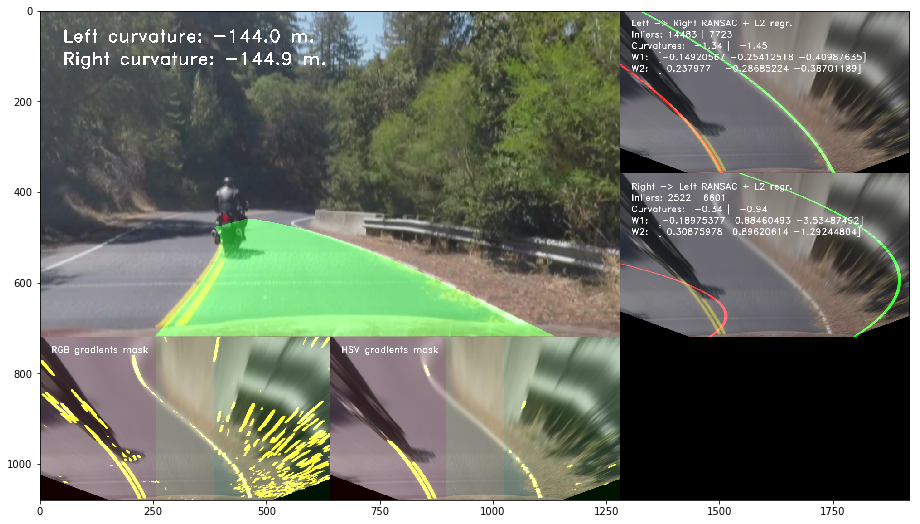

In [87]:
dimg = debug_frame(mask_img, wimg, wmasks, lmask, rmask, lanes_ransac)

f, ax = plt.subplots(1, 1, figsize=(24, 9))
plt.imshow(dimg)

## Process individual images

The pipeline used is equivalent to the example above.

In [94]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def warped_masks(img, m_perp, thresholds=[20, 25]):
    """Generate a collection of masks useful to detect lines.
    """
    wmasks = []
    # Grayscale and HSL images
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    gammas = [1.]
    for g in gammas:
        img_gamma = adjust_gamma(img, gamma=g)
        # Warped images.
        wimg = warp_image(img_gamma, m_perp, flags=cv2.INTER_LANCZOS4)
        wgray = cv2.cvtColor(wimg, cv2.COLOR_RGB2GRAY)
        whsl = cv2.cvtColor(wimg, cv2.COLOR_RGB2HLS)

        # Compute gradients.
        skernel = 13
        wsobel_dx = gradient_x(wgray, sobel_kernel=skernel)
        ws_sobel_dx = gradient_x(whsl[:, :, 2], sobel_kernel=skernel)

        # Try to detect gradients configuration corresponding to lanes.
        mask = mask_local_crossing_x(wsobel_dx, threshold=thresholds[0],
                                     dilate_kernel=(2, 8), iterations=3)
        wmasks.append(mask)
        mask = mask_local_crossing_x(ws_sobel_dx, threshold=thresholds[1],
                                     dilate_kernel=(2, 8), iterations=3)
        wmasks.append(mask)

    return wmasks

def process_image(path, fname, debug=True):
    path_save = 'debug/'
    img_name = fname[:-4]
    img = load_image(path + fname)
    img = undistort_image(img, mtx, dist)
    wimg = warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)
    
    # Warped image and masks
    wimg = warp_image(img, mtx_perp, flags=cv2.INTER_LANCZOS4)
    wmasks = warped_masks(img, mtx_perp, thresholds=[25, 30])
    lmask, rmask = default_left_right_masks(img, margin=0.1)
 
    # Masks points.
    X1, y1 = masks_to_points(wmasks, lmask, order=2, reverse_x=True, normalise=True, dtype=np.float64)
    X2, y2 = masks_to_points(wmasks, rmask, order=2, reverse_x=True, normalise=True, dtype=np.float64)
    
    # Model validation bounds.
    left_right_bounds = np.zeros((1, 3, 2), dtype=X1.dtype)
    left_right_bounds[0, 0, 0] = 0.25
    left_right_bounds[0, 0, 1] = 0.5
    left_right_bounds[0, 1, 1] = 0.2
    left_right_bounds[0, 2, 1] = 0.1
    valid_bounds = np.zeros((0, 3, 2), dtype=X1.dtype)

    # Fit regression.
    res_threshold = 0.01
    l2_scales = np.array([0.005, 0.005], dtype=X1.dtype)
    score_lambdas = np.array([10., 1., 1., 1.], dtype=X1.dtype)
    n_prefits = 5000
    max_trials = 500000
    lanes_ransac = SLanesRANSACRegressor(residual_threshold=res_threshold, 
                                         n_prefits=n_prefits,
                                         max_trials=max_trials,
                                         l2_scales=l2_scales,
                                         score_lambdas=score_lambdas)
    lanes_ransac.fit(X1, y1, X2, y2, left_right_bounds)
    
    # Lane mask.
    X_lane, y1_lane, y2_lane = predict_lanes(lanes_ransac, wimg, reversed_x=True, normalised=True)
    x_lane = X_lane[:, 1]
    wmask_lane = lanes_to_wmask(wimg, x_lane, y1_lane, x_lane, y2_lane)
    wimg_lane = cv2.addWeighted(wimg, 0.9, wmask_lane, 0.4, 0.)
    
    # Unwarp everything!
    mask_lane = warp_image(wmask_lane, mtx_perp_inv, flags=cv2.INTER_NEAREST)
    img_lane = cv2.addWeighted(img, 0.9, mask_lane, 0.4, 0.)
    
    #print("Solution is wmaks_lane!")

    # Add curvature and position information.
    curv_left = lane_curvature(rescale_coefficients(wimg, lanes_ransac.w1_, perp_scaling))
    curv_right = lane_curvature(rescale_coefficients(wimg, lanes_ransac.w2_, perp_scaling))
    position = -(lanes_ransac.w1_[0] + lanes_ransac.w2_[0]) / 2. * img.shape[1] * perp_scaling[1]
    
    cv2.putText(img_lane, "Left curvature: %.1f m." % curv_left, (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(img_lane, "Right curvature: %.1f m." % curv_right, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(img_lane, "Off the center: %.1f m." % position, (50, 170), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

    if debug:
        img_lane = debug_frame(img_lane, wimg, wmasks, lmask, rmask, lanes_ransac)
    
    # Save images.
    # mpimg.imsave(path_save+img_name+'_wlane.jpg', wimg_lane)
    mpimg.imsave(path_save+img_name+'_lane.jpg', img_lane)

In [95]:
# Full pipeline on test images.
path = 'test_images/'
filenames = os.listdir(path)
for fname in filenames:
    print('Processing image: ', fname)
    process_image(path, fname)

Processing image:  test (19).jpg
Processing image:  test (6).jpg
Processing image:  test (11).jpg
Processing image:  test5.jpg
Processing image:  test (4).jpg
Processing image:  test3.jpg
Processing image:  test (16).jpg
Processing image:  test (5).jpg
Processing image:  test (8).jpg
Processing image:  test (14).jpg
Processing image:  test2.jpg
Processing image:  signs_vehicles_xygrad.jpg
Processing image:  test (10).jpg
Processing image:  test (3).jpg
Processing image:  test (7).jpg
Processing image:  test (18).jpg
Processing image:  test (13).jpg
Processing image:  test (12).jpg
Processing image:  test6.jpg
Processing image:  test (9).jpg
Processing image:  test17.jpg
Processing image:  test1.jpg
Processing image:  test12.jpg
Processing image:  test (15).jpg
Processing image:  test (1).jpg
Processing image:  test (2).jpg
Processing image:  test4.jpg


## Process video frames

The pipeline is very similar to the previous image pipeline. The only modification is the use of previous frames to help lanes fitting.

In [98]:
class LanesFit():
    """Lanes fit class: contain information on a previous fit of lanes.
    """
    def __init__(self):
        # Interpolation coefficients.
        self.w_left = np.zeros((3,), dtype=np.float32)
        self.w_right = np.zeros((3,), dtype=np.float32)
        # Fitting score.
        self.fit_score_left = 0.0
        self.fit_score_right = 0.0

        # Scaling and original shape.
        self.shape = (1, 1)
        self.scaling = (1., 1.)
        self.shift = (0., 0.5)
        self.reversed = True

        # Radius of curvature, in w units.
        self.radius = 0.0
        self.line_base_pos = 0.0

    def init_from_regressor(self, regr):
        """Initialise values from a regression object.
        """
        self.w_left = regr.w1_
        self.w_right = regr.w2_
        self.fit_score_left = float(np.sum(regr.inlier_mask1_)) / regr.inlier_mask1_.size
        self.fit_score_right = float(np.sum(regr.inlier_mask2_)) / regr.inlier_mask2_.size

    def translate_coefficients(self, delta):
        """Translate lanes while keeping same curvature center.
        """
        w_left = self.w_left
        w1 = np.copy(self.w_left)
        w1[0] = delta + w_left[0]
        w1[1] = w_left[1]
        w1[2] = w_left[2] * (1 + w_left[1]**2)**1.5 / ((1 + w_left[1]**2)**1.5 - 2*delta*w_left[2])

        w_right = self.w_right
        w2 = np.copy(self.w_right)
        w2[0] = delta + w_right[0]
        w2[1] = w_right[1]
        w2[2] = w_right[2] * (1 + w_right[1]**2)**1.5 / ((1 + w_right[1]**2)**1.5 - 2*delta*w_right[2])
        return w1, w2
    
    def masks(self, delta):
        """Compute lanes mask, using a +- delta on every lane.
        """
        delta = np.abs(delta)
        # Meshgrid
        xv, yv = np.mgrid[0:self.shape[0], 0:self.shape[1]]
        xv = xv / float(self.scaling[0]) - self.shift[0]
        yv = yv / float(self.scaling[1]) - self.shift[1]
        if self.reversed:
            xv = xv[::-1]

        # Left part of the masks.
        w1, w2 = self.translate_coefficients(delta)
        y1 = w1[0] + w1[1] * xv + w1[2] * xv**2
        y2 = w2[0] + w2[1] * xv + w2[2] * xv**2
        lmask = yv <= y1
        rmask = yv <= y2

        # Right part of the masks.
        w1, w2 = self.translate_coefficients(-delta)
        y1 = w1[0] + w1[1] * xv + w1[2] * xv**2
        y2 = w2[0] + w2[1] * xv + w2[2] * xv**2
        lmask = np.logical_and(lmask, yv >= y1)
        rmask = np.logical_and(rmask, yv >= y2)

        return lmask, rmask

In [141]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

def process_frame(img_orig, debug=True):
    lanes_past = process_frame.lanes_past
    
    img = undistort_image(img_orig, mtx, dist)
    wimg = warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)
    # Warped image and masks
    wmasks = warped_masks(img, mtx_perp, thresholds=[20, 25])
    
    #wmasks_row = np.average(wmasks, axis = 0)
    #wmasks_avg = np.average(wmasks_row, axis = 0)
    #print("avg_color_row")
    #print(avg_color_row)
    #avg_color = np.average(avg_color_row, axis = 0)
    #print(wmasks_avg)
    
    # Masks...
    if len(lanes_past) > 0:
        delta = 0.1
        lmask, rmask = lanes_past[-1].masks(delta)
    else:
        lmask, rmask = default_left_right_masks(img, margin=0.1)
    
    # Masks points.
    X1, y1 = masks_to_points(wmasks, lmask, order=2, reverse_x=True, normalise=True, dtype=np.float32)
    X2, y2 = masks_to_points(wmasks, rmask, order=2, reverse_x=True, normalise=True, dtype=np.float32)

    # Model validation bounds.
    left_right_bounds = np.zeros((1, 3, 2), dtype=X1.dtype)
    left_right_bounds[0, 0, 0] = 0.25
    left_right_bounds[0, 0, 1] = 0.5
    left_right_bounds[0, 1, 1] = 0.25
    left_right_bounds[0, 2, 1] = 0.15
    
    # Left and right validation bounds.
    w_refs_left = None
    w_refs_right = None
    is_valid_bounds_left = None
    is_valid_bounds_right = None
    if len(lanes_past) > 0:
        lanes = lanes_past[-1]
        w_refs_left = np.copy(lanes.w_left).reshape((1, 3))
        w_refs_right = np.copy(lanes.w_right).reshape((1, 3))
        
        is_valid_bounds_left = np.zeros((1, 3, 2), dtype=X1.dtype)
        is_valid_bounds_left[0, 0, 1] = 1.
        is_valid_bounds_left[0, 1, 1] = 1.
        is_valid_bounds_left[0, 2, 1] = 1.
        is_valid_bounds_right = np.copy(is_valid_bounds_left)

    # Fit regression.
    res_threshold = 0.01
    l2_scales = np.array([0.005, 0.005], dtype=X1.dtype)
    score_lambdas = np.array([10., 1., 1., 1.], dtype=X1.dtype)
    smoothing = 0.3
    n_prefits = 5000
    max_trials = 500000
    if len(lanes_past) < 1:
        n_prefits *= 10
        max_trials *= 10
    lanes_ransac = SLanesRANSACRegressor(residual_threshold=res_threshold, 
                                         n_prefits=n_prefits, max_trials=max_trials,
                                         l2_scales=l2_scales, smoothing=smoothing,
                                         score_lambdas=score_lambdas,
                                         w_refs_left=w_refs_left, is_valid_bounds_left=is_valid_bounds_left,
                                         w_refs_right=w_refs_right, is_valid_bounds_right=is_valid_bounds_right)
    lanes_ransac.fit(X1, y1, X2, y2, left_right_bounds)
    
    # Save lanes fit.
    lanes_fit = LanesFit()
    lanes_fit.init_from_regressor(lanes_ransac)
    lanes_fit.shape = wimg.shape
    lanes_fit.scaling = wimg.shape
    
    if len(lanes_past) > 400:
        lanes_past.pop(0)
    lanes_past.append(lanes_fit)
    process_frame.lanes_past = lanes_past
    
    # Lane mask.
    X_lane, y1_lane, y2_lane = predict_lanes(lanes_ransac, wimg, reversed_x=True, normalised=True)
    x_lane = X_lane[:, 1]
    wmask_lane = lanes_to_wmask(wimg, x_lane, y1_lane, x_lane, y2_lane)
    # Unwarp everything!
    mask_lane = warp_image(wmask_lane, mtx_perp_inv, flags=cv2.INTER_NEAREST)
    img_lane = cv2.addWeighted(img, 0.9, mask_lane, 0.4, 0.)
    # Add curvature information.
    curv_left = lane_curvature(rescale_coefficients(wimg, lanes_ransac.w1_, perp_scaling))
    curv_right = lane_curvature(rescale_coefficients(wimg, lanes_ransac.w2_, perp_scaling))
    position = -(lanes_ransac.w1_[0] + lanes_ransac.w2_[0]) / 2. * img.shape[1] * perp_scaling[1]
    
    cv2.putText(img_lane, "Left curvature: %.1f m." % curv_left, (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(img_lane, "Right curvature: %.1f m." % curv_right, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(img_lane, "Off the center: %.1f m." % position, (50, 170), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

    if debug:
        img_lane = debug_frame(img_lane, wimg, wmasks, lmask, rmask, lanes_ransac)
        
    return img_lane

In [142]:
process_frame.lanes_past = []

# Let's check to Illumination Problem.
white_output = 'harder_challenge_debug.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(35, 45)
#clip1.set_start(500)
#clip1.set_end(650)
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_debug.mp4
[MoviePy] Writing video harder_challenge_debug.mp4


100%|█████████▉| 250/251 [08:05<00:01,  1.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_debug.mp4 

CPU times: user 20min 46s, sys: 17.6 s, total: 21min 3s
Wall time: 8min 7s


TEST on image: test_images/test17.jpg (720, 1280, 3)
[379, 890]


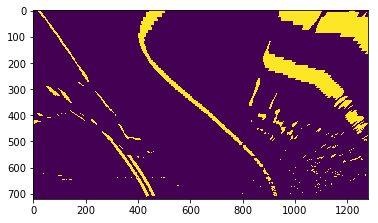

In [134]:
from math import *
from scipy.signal import find_peaks_cwt

# Test on some image...
fname = path + os.listdir(path)[20]
image = lane.undistort_image(lane.load_image(fname), mtx, dist)
# img = adjust_gamma(img, gamma=1.)
wimg = warp_image(image, mtx_perp, flags=cv2.INTER_LINEAR)
print('TEST on image:', fname, img.shape)
#image = cv2.GaussianBlur(image, (1, 11), 0)

def find_edges(image, mask_half=False):
    s = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2HLS)[:,:,2]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, gray_binary = cv2.threshold(gray.astype('uint8'), 130, 255, cv2.THRESH_BINARY)
    total_px = image.shape[0]*image.shape[1]
    laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
    mask_one = (laplacian < 0.15*np.min(laplacian)).astype(np.uint8)
    if cv2.countNonZero(mask_one)/total_px < 0.01:
        laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
        mask_one = (laplacian < 0.075*np.min(laplacian)).astype(np.uint8)
    _, s_binary = cv2.threshold(s.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
    mask_two = s_binary
    
    mask_one_row = np.average(mask_one, axis = 0)
    mask_one_row_avg = np.average(mask_one_row, axis = 0)
    #print(mask_one_row_avg)

    combined_binary = np.clip(cv2.bitwise_and(gray_binary,
                        cv2.bitwise_or(mask_one, mask_two)), 0, 1).astype('uint8')
    return combined_binary

def get_perspective_transform(image, src_in = None, dst_in = None):
    img_size = image.shape

    src = src_in
    dst = dst_in

    if src_in == None:
        src = np.array([[585. /1280.*img_size[1], 455./720.*img_size[0]],
                    [705. /1280.*img_size[1], 455./720.*img_size[0]],
                    [1130./1280.*img_size[1], 720./720.*img_size[0]],
                    [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    if dst_in == None:
        dst = np.array([[300. /1280.*img_size[1], 100./720.*img_size[0]],
                    [1000./1280.*img_size[1], 100./720.*img_size[0]],
                    [1000./1280.*img_size[1], 720./720.*img_size[0]],
                    [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)

    warp_m = cv2.getPerspectiveTransform(src, dst)
    warp_minv = cv2.getPerspectiveTransform(dst, src)
    return warp_m, warp_minv

def find_perspective_points(image):
    edges = find_edges(image)
    rho = 2
    theta = 1*np.pi/180
    threshold = 100
    min_line_length = 100
    max_line_gap = 25
    angle_min_mag = 20*pi/180
    angle_max_mag = 65*pi/180
    lane_markers_x = [[], []]
    lane_markers_y = [[], []]

    masked_edges = np.copy(edges)
    masked_edges[:edges.shape[0]*6//10,:] = 0
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    for line in lines:
        for x1,y1,x2,y2 in line:
            theta = atan2(y1-y2, x2-x1)
            rho = ((x1+x2)*cos(theta) + (y1+y2)*sin(theta))/2
            if (abs(theta) >= angle_min_mag and abs(theta) <= angle_max_mag):
                if theta > 0: # positive theta is downward in image space?
                    i = 0 # Left lane marker
                else:
                    i = 1 # Right lane marker
                lane_markers_x[i].append(x1)
                lane_markers_x[i].append(x2)
                lane_markers_y[i].append(y1)
                lane_markers_y[i].append(y2)

    if len(lane_markers_x[0]) < 1 or len(lane_markers_x[1]) < 1:
        # Failed to find lane markers,use defaults
        return default_src

    p_left  = np.polyfit(lane_markers_y[0], lane_markers_x[0], 1)
    p_right = np.polyfit(lane_markers_y[1], lane_markers_x[1], 1)

    # Find intersection of the two lines
    apex_pt = np.linalg.solve([[p_left[0], -1], [p_right[0], -1]], [-p_left[1], -p_right[1]])
    top_y = ceil(apex_pt[0] + 0.075*edges.shape[0])

    bl_pt = ceil(np.polyval(p_left, edges.shape[0]))
    tl_pt = ceil(np.polyval(p_left, top_y))

    br_pt = ceil(np.polyval(p_right, edges.shape[0]))
    tr_pt = ceil(np.polyval(p_right, top_y))

    src = np.array([[tl_pt, top_y],
                    [tr_pt, top_y],
                    [br_pt, edges.shape[0]],
                    [bl_pt, edges.shape[0]]], np.float32)

    get_perspective_transform(edges, src_in = src)
    
    return src

def histogram_base_points(lanes, min_peak = 25.0):
    """Uses histogram to find possible base points for lane lines"""
    hist = np.sum(lanes[int(lanes.shape[0]*0.5):,:], axis=0)

    widths = [100]
    idx = find_peaks_cwt(hist, widths, max_distances=widths, noise_perc=50)
    if len(idx) < 2:
        return None

    # Avoid edges
    idx = [i for i in idx if i > lanes.shape[1]*0.1
                             and i < lanes.shape[1]*0.9
                             and max(hist[i-50:i+50]) > min_peak]

    return [min(idx), max(idx)]

def detect_from_mask(self, image, mask):
    mask_lanes = cv2.bitwise_and(image, mask)
    all_pts = cv2.findNonZero(mask_lanes)
    if all_pts is not None:
        all_pts = all_pts.reshape((-1,2))
        add_lane_pixels(all_pts[:,0], all_pts[:,1])
    else:
        detected = False
        
    return all_pts

#plt.imshow(image)
src = find_perspective_points(image)
#plt.imshow(src)
warp_m, warp_minv = get_perspective_transform(image, src_in = src)
edges = find_edges(image)
#plt.imshow(edges)
warp_edges = cv2.warpPerspective(edges, warp_m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
mask = np.ones(image.shape[:2], dtype=np.uint8) * 255
plt.imshow(warp_edges)

wimg = warp_image(edges, mtx_perp, flags=cv2.INTER_LINEAR)
plt.imshow(wimg)

new_base_pts = histogram_base_points(wimg)

if new_base_pts is not None:
    base_pts = new_base_pts
    
print(new_base_pts)

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

def process_frame(img_orig, debug=True):
    lanes_past = process_frame.lanes_past
    
    img = undistort_image(img_orig, mtx, dist)
    wimg = warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)
    wmasks = warped_masks(img, mtx_perp, thresholds=[20, 25])
    
    # Masks...
    if len(lanes_past) > 0:
        delta = 0.1
        lmask, rmask = lanes_past[-1].masks(delta)
    else:
        lmask, rmask = default_left_right_masks(img, margin=0.1)
    
    # Masks points.
    X1, y1 = masks_to_points(wmasks, lmask, order=2, reverse_x=True, normalise=True, dtype=np.float32)
    X2, y2 = masks_to_points(wmasks, rmask, order=2, reverse_x=True, normalise=True, dtype=np.float32)

    # Model validation bounds.
    left_right_bounds = np.zeros((1, 3, 2), dtype=X1.dtype)
    left_right_bounds[0, 0, 0] = 0.25
    left_right_bounds[0, 0, 1] = 0.5
    left_right_bounds[0, 1, 1] = 0.25
    left_right_bounds[0, 2, 1] = 0.15
    
    # Left and right validation bounds.
    w_refs_left = None
    w_refs_right = None
    is_valid_bounds_left = None
    is_valid_bounds_right = None
    if len(lanes_past) > 0:
        lanes = lanes_past[-1]
        w_refs_left = np.copy(lanes.w_left).reshape((1, 3))
        w_refs_right = np.copy(lanes.w_right).reshape((1, 3))
        
        is_valid_bounds_left = np.zeros((1, 3, 2), dtype=X1.dtype)
        is_valid_bounds_left[0, 0, 1] = 1.
        is_valid_bounds_left[0, 1, 1] = 1.
        is_valid_bounds_left[0, 2, 1] = 1.
        is_valid_bounds_right = np.copy(is_valid_bounds_left)

    # Fit regression.
    res_threshold = 0.01
    l2_scales = np.array([0.005, 0.005], dtype=X1.dtype)
    score_lambdas = np.array([10., 1., 1., 1.], dtype=X1.dtype)
    smoothing = 0.3
    n_prefits = 5000
    max_trials = 500000
    if len(lanes_past) < 1:
        n_prefits *= 10
        max_trials *= 10
    lanes_ransac = SLanesRANSACRegressor(residual_threshold=res_threshold, 
                                         n_prefits=n_prefits, max_trials=max_trials,
                                         l2_scales=l2_scales, smoothing=smoothing,
                                         score_lambdas=score_lambdas,
                                         w_refs_left=w_refs_left, is_valid_bounds_left=is_valid_bounds_left,
                                         w_refs_right=w_refs_right, is_valid_bounds_right=is_valid_bounds_right)
    lanes_ransac.fit(X1, y1, X2, y2, left_right_bounds)
    
    # Save lanes fit.
    lanes_fit = LanesFit()
    lanes_fit.init_from_regressor(lanes_ransac)
    lanes_fit.shape = wimg.shape
    lanes_fit.scaling = wimg.shape
    
    if len(lanes_past) > 20:
        lanes_past.pop(0)
    lanes_past.append(lanes_fit)
    process_frame.lanes_past = lanes_past
    
    # Lane mask.
    X_lane, y1_lane, y2_lane = predict_lanes(lanes_ransac, wimg, reversed_x=True, normalised=True)
    x_lane = X_lane[:, 1]
    wmask_lane = lanes_to_wmask(wimg, x_lane, y1_lane, x_lane, y2_lane)
    # Unwarp everything!
    mask_lane = warp_image(wmask_lane, mtx_perp_inv, flags=cv2.INTER_NEAREST)
    img_lane = cv2.addWeighted(img, 0.9, mask_lane, 0.4, 0.)
    # Add curvature information.
    curv_left = lane_curvature(rescale_coefficients(wimg, lanes_ransac.w1_, perp_scaling))
    curv_right = lane_curvature(rescale_coefficients(wimg, lanes_ransac.w2_, perp_scaling))
    position = -(lanes_ransac.w1_[0] + lanes_ransac.w2_[0]) / 2. * img.shape[1] * perp_scaling[1]
    
    cv2.putText(img_lane, "Left curvature: %.1f m." % curv_left, (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(img_lane, "Right curvature: %.1f m." % curv_right, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(img_lane, "Off the center: %.1f m." % position, (50, 170), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)

    if debug:
        img_lane = debug_frame(img_lane, wimg, wmasks, lmask, rmask, lanes_ransac)
        
    return img_lane

In [62]:
process_frame.lanes_past = []

white_output = 'project_video_lane.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(white_output, audio=False)

center:
[[[ 702.  359.]
  [ 702.  359.]
  [ 702.  359.]
  ..., 
  [ 671.  359.]
  [ 671.  359.]
  [ 671.  359.]]]
[MoviePy] >>>> Building video project_video_lane.mp4
[MoviePy] Writing video project_video_lane.mp4


  0%|          | 1/1261 [00:00<19:46,  1.06it/s]

center:
[[[ 702.  359.]
  [ 702.  359.]
  [ 702.  359.]
  ..., 
  [ 671.  359.]
  [ 671.  359.]
  [ 671.  359.]]]


  0%|          | 2/1261 [00:01<19:38,  1.07it/s]

center:
[[[ 702.  359.]
  [ 702.  359.]
  [ 702.  359.]
  ..., 
  [ 670.  359.]
  [ 670.  359.]
  [ 670.  359.]]]


  0%|          | 3/1261 [00:02<19:26,  1.08it/s]

center:
[[[ 702.  359.]
  [ 702.  359.]
  [ 702.  359.]
  ..., 
  [ 668.  359.]
  [ 668.  359.]
  [ 668.  359.]]]


  0%|          | 4/1261 [00:03<19:12,  1.09it/s]

center:
[[[ 701.  359.]
  [ 701.  359.]
  [ 701.  359.]
  ..., 
  [ 666.  359.]
  [ 666.  359.]
  [ 665.  359.]]]


  0%|          | 5/1261 [00:04<18:56,  1.11it/s]

center:
[[[ 701.  359.]
  [ 701.  359.]
  [ 701.  359.]
  ..., 
  [ 664.  359.]
  [ 664.  359.]
  [ 664.  359.]]]


  0%|          | 6/1261 [00:05<18:44,  1.12it/s]

center:
[[[ 700.  359.]
  [ 700.  359.]
  [ 700.  359.]
  ..., 
  [ 663.  359.]
  [ 662.  359.]
  [ 662.  359.]]]


  1%|          | 7/1261 [00:06<18:36,  1.12it/s]

center:
[[[ 700.  359.]
  [ 700.  359.]
  [ 700.  359.]
  ..., 
  [ 662.  359.]
  [ 662.  359.]
  [ 662.  359.]]]


  1%|          | 8/1261 [00:07<19:05,  1.09it/s]

center:
[[[ 700.  359.]
  [ 700.  359.]
  [ 700.  359.]
  ..., 
  [ 662.  359.]
  [ 662.  359.]
  [ 662.  359.]]]


  1%|          | 9/1261 [00:08<19:21,  1.08it/s]

center:
[[[ 700.  359.]
  [ 700.  359.]
  [ 700.  359.]
  ..., 
  [ 662.  359.]
  [ 662.  359.]
  [ 662.  359.]]]


  1%|          | 10/1261 [00:09<19:26,  1.07it/s]

center:
[[[ 699.  359.]
  [ 699.  359.]
  [ 699.  359.]
  ..., 
  [ 662.  359.]
  [ 662.  359.]
  [ 662.  359.]]]


  1%|          | 11/1261 [00:10<19:28,  1.07it/s]

center:
[[[ 698.  359.]
  [ 699.  359.]
  [ 699.  359.]
  ..., 
  [ 662.  359.]
  [ 661.  359.]
  [ 661.  359.]]]


  1%|          | 12/1261 [00:11<19:35,  1.06it/s]

center:
[[[ 698.  359.]
  [ 698.  359.]
  [ 698.  359.]
  ..., 
  [ 663.  359.]
  [ 663.  359.]
  [ 663.  359.]]]


  1%|          | 13/1261 [00:12<20:07,  1.03it/s]

center:
[[[ 697.  359.]
  [ 697.  359.]
  [ 698.  359.]
  ..., 
  [ 664.  359.]
  [ 664.  359.]
  [ 664.  359.]]]


  1%|          | 14/1261 [00:13<20:09,  1.03it/s]

center:
[[[ 697.  359.]
  [ 697.  359.]
  [ 697.  359.]
  ..., 
  [ 664.  359.]
  [ 664.  359.]
  [ 664.  359.]]]


  1%|          | 15/1261 [00:14<19:55,  1.04it/s]

center:
[[[ 697.  359.]
  [ 697.  359.]
  [ 697.  359.]
  ..., 
  [ 662.  359.]
  [ 662.  359.]
  [ 662.  359.]]]


  1%|▏         | 16/1261 [00:14<19:35,  1.06it/s]

center:
[[[ 696.  359.]
  [ 696.  359.]
  [ 696.  359.]
  ..., 
  [ 659.  359.]
  [ 659.  359.]
  [ 659.  359.]]]


  1%|▏         | 17/1261 [00:15<19:15,  1.08it/s]

center:
[[[ 695.  359.]
  [ 695.  359.]
  [ 695.  359.]
  ..., 
  [ 656.  359.]
  [ 656.  359.]
  [ 656.  359.]]]


  1%|▏         | 18/1261 [00:16<19:01,  1.09it/s]

center:
[[[ 694.  359.]
  [ 694.  359.]
  [ 694.  359.]
  ..., 
  [ 654.  359.]
  [ 654.  359.]
  [ 654.  359.]]]


  2%|▏         | 19/1261 [00:17<18:49,  1.10it/s]

center:
[[[ 693.  359.]
  [ 693.  359.]
  [ 693.  359.]
  ..., 
  [ 654.  359.]
  [ 654.  359.]
  [ 654.  359.]]]


  2%|▏         | 20/1261 [00:18<18:47,  1.10it/s]

center:
[[[ 693.  359.]
  [ 693.  359.]
  [ 693.  359.]
  ..., 
  [ 654.  359.]
  [ 654.  359.]
  [ 654.  359.]]]


  2%|▏         | 21/1261 [00:19<18:58,  1.09it/s]

center:
[[[ 692.  359.]
  [ 692.  359.]
  [ 692.  359.]
  ..., 
  [ 656.  359.]
  [ 655.  359.]
  [ 655.  359.]]]


  2%|▏         | 22/1261 [00:20<19:08,  1.08it/s]

center:
[[[ 691.  359.]
  [ 692.  359.]
  [ 692.  359.]
  ..., 
  [ 658.  359.]
  [ 657.  359.]
  [ 657.  359.]]]


  2%|▏         | 23/1261 [00:21<19:14,  1.07it/s]

center:
[[[ 690.  359.]
  [ 690.  359.]
  [ 690.  359.]
  ..., 
  [ 660.  359.]
  [ 659.  359.]
  [ 659.  359.]]]


  2%|▏         | 24/1261 [00:22<19:19,  1.07it/s]

center:
[[[ 690.  359.]
  [ 690.  359.]
  [ 690.  359.]
  ..., 
  [ 660.  359.]
  [ 660.  359.]
  [ 660.  359.]]]


  2%|▏         | 25/1261 [00:23<19:14,  1.07it/s]

center:
[[[ 690.  359.]
  [ 690.  359.]
  [ 690.  359.]
  ..., 
  [ 659.  359.]
  [ 659.  359.]
  [ 659.  359.]]]


  2%|▏         | 26/1261 [00:24<19:10,  1.07it/s]

center:
[[[ 690.  359.]
  [ 690.  359.]
  [ 690.  359.]
  ..., 
  [ 660.  359.]
  [ 659.  359.]
  [ 659.  359.]]]


  2%|▏         | 27/1261 [00:25<19:06,  1.08it/s]

center:
[[[ 690.  359.]
  [ 690.  359.]
  [ 690.  359.]
  ..., 
  [ 660.  359.]
  [ 660.  359.]
  [ 660.  359.]]]


  2%|▏         | 28/1261 [00:25<19:08,  1.07it/s]

center:
[[[ 691.  359.]
  [ 691.  359.]
  [ 691.  359.]
  ..., 
  [ 662.  359.]
  [ 662.  359.]
  [ 662.  359.]]]


  2%|▏         | 29/1261 [00:26<19:17,  1.06it/s]

center:
[[[ 691.  359.]
  [ 691.  359.]
  [ 691.  359.]
  ..., 
  [ 663.  359.]
  [ 662.  359.]
  [ 662.  359.]]]


  2%|▏         | 30/1261 [00:27<18:55,  1.08it/s]

center:
[[[ 691.  359.]
  [ 691.  359.]
  [ 691.  359.]
  ..., 
  [ 660.  359.]
  [ 660.  359.]
  [ 660.  359.]]]


  2%|▏         | 31/1261 [00:28<18:31,  1.11it/s]

center:
[[[ 692.  359.]
  [ 692.  359.]
  [ 692.  359.]
  ..., 
  [ 656.  359.]
  [ 656.  359.]
  [ 656.  359.]]]


  3%|▎         | 32/1261 [00:29<18:08,  1.13it/s]

center:
[[[ 692.  359.]
  [ 692.  359.]
  [ 692.  359.]
  ..., 
  [ 653.  359.]
  [ 653.  359.]
  [ 653.  359.]]]


  3%|▎         | 33/1261 [00:30<18:06,  1.13it/s]

center:
[[[ 692.  359.]
  [ 692.  359.]
  [ 692.  359.]
  ..., 
  [ 652.  359.]
  [ 652.  359.]
  [ 651.  359.]]]


  3%|▎         | 34/1261 [00:31<18:11,  1.12it/s]

center:
[[[ 691.  359.]
  [ 691.  359.]
  [ 691.  359.]
  ..., 
  [ 651.  359.]
  [ 651.  359.]
  [ 650.  359.]]]


  3%|▎         | 35/1261 [00:32<18:10,  1.12it/s]

center:
[[[ 690.  359.]
  [ 690.  359.]
  [ 690.  359.]
  ..., 
  [ 650.  359.]
  [ 650.  359.]
  [ 650.  359.]]]


  3%|▎         | 36/1261 [00:33<18:10,  1.12it/s]

center:
[[[ 690.  359.]
  [ 690.  359.]
  [ 690.  359.]
  ..., 
  [ 648.  359.]
  [ 648.  359.]
  [ 648.  359.]]]


  3%|▎         | 37/1261 [00:33<18:13,  1.12it/s]

center:
[[[ 689.  359.]
  [ 689.  359.]
  [ 689.  359.]
  ..., 
  [ 648.  359.]
  [ 648.  359.]
  [ 647.  359.]]]


  3%|▎         | 38/1261 [00:34<18:16,  1.11it/s]

center:
[[[ 689.  359.]
  [ 689.  359.]
  [ 689.  359.]
  ..., 
  [ 647.  359.]
  [ 647.  359.]
  [ 647.  359.]]]


  3%|▎         | 39/1261 [00:35<18:14,  1.12it/s]

center:
[[[ 687.  359.]
  [ 688.  359.]
  [ 688.  359.]
  ..., 
  [ 645.  359.]
  [ 645.  359.]
  [ 645.  359.]]]


  3%|▎         | 40/1261 [00:36<18:04,  1.13it/s]

center:
[[[ 687.  359.]
  [ 687.  359.]
  [ 687.  359.]
  ..., 
  [ 644.  359.]
  [ 644.  359.]
  [ 643.  359.]]]


  3%|▎         | 41/1261 [00:37<18:00,  1.13it/s]

center:
[[[ 687.  359.]
  [ 687.  359.]
  [ 687.  359.]
  ..., 
  [ 643.  359.]
  [ 643.  359.]
  [ 643.  359.]]]


  3%|▎         | 42/1261 [00:38<17:54,  1.13it/s]

center:
[[[ 686.  359.]
  [ 687.  359.]
  [ 687.  359.]
  ..., 
  [ 643.  359.]
  [ 643.  359.]
  [ 643.  359.]]]


  3%|▎         | 43/1261 [00:39<17:54,  1.13it/s]

center:
[[[ 686.  359.]
  [ 686.  359.]
  [ 686.  359.]
  ..., 
  [ 643.  359.]
  [ 642.  359.]
  [ 642.  359.]]]


  3%|▎         | 44/1261 [00:40<17:39,  1.15it/s]

center:
[[[ 685.  359.]
  [ 686.  359.]
  [ 686.  359.]
  ..., 
  [ 644.  359.]
  [ 643.  359.]
  [ 643.  359.]]]


  4%|▎         | 45/1261 [00:41<17:33,  1.15it/s]

center:
[[[ 685.  359.]
  [ 685.  359.]
  [ 685.  359.]
  ..., 
  [ 645.  359.]
  [ 645.  359.]
  [ 645.  359.]]]


  4%|▎         | 46/1261 [00:41<17:45,  1.14it/s]

center:
[[[ 684.  359.]
  [ 684.  359.]
  [ 684.  359.]
  ..., 
  [ 647.  359.]
  [ 647.  359.]
  [ 646.  359.]]]


  4%|▎         | 47/1261 [00:42<18:05,  1.12it/s]

center:
[[[ 683.  359.]
  [ 683.  359.]
  [ 683.  359.]
  ..., 
  [ 648.  359.]
  [ 648.  359.]
  [ 648.  359.]]]


  4%|▍         | 48/1261 [00:43<18:08,  1.11it/s]

center:
[[[ 683.  359.]
  [ 683.  359.]
  [ 683.  359.]
  ..., 
  [ 649.  359.]
  [ 649.  359.]
  [ 648.  359.]]]


  4%|▍         | 49/1261 [00:44<18:17,  1.10it/s]

center:
[[[ 683.  359.]
  [ 683.  359.]
  [ 683.  359.]
  ..., 
  [ 650.  359.]
  [ 650.  359.]
  [ 650.  359.]]]


  4%|▍         | 50/1261 [00:45<18:23,  1.10it/s]

center:
[[[ 683.  359.]
  [ 683.  359.]
  [ 683.  359.]
  ..., 
  [ 650.  359.]
  [ 650.  359.]
  [ 650.  359.]]]


  4%|▍         | 51/1261 [00:46<18:26,  1.09it/s]

center:
[[[ 684.  359.]
  [ 684.  359.]
  [ 684.  359.]
  ..., 
  [ 651.  359.]
  [ 651.  359.]
  [ 651.  359.]]]


  4%|▍         | 52/1261 [00:47<18:34,  1.08it/s]

center:
[[[ 684.  359.]
  [ 685.  359.]
  [ 685.  359.]
  ..., 
  [ 651.  359.]
  [ 651.  359.]
  [ 651.  359.]]]


  4%|▍         | 53/1261 [00:48<18:37,  1.08it/s]

center:
[[[ 684.  359.]
  [ 684.  359.]
  [ 684.  359.]
  ..., 
  [ 649.  359.]
  [ 649.  359.]
  [ 649.  359.]]]


  4%|▍         | 54/1261 [00:49<18:49,  1.07it/s]

center:
[[[ 684.  359.]
  [ 684.  359.]
  [ 684.  359.]
  ..., 
  [ 648.  359.]
  [ 648.  359.]
  [ 648.  359.]]]


  4%|▍         | 55/1261 [00:50<18:39,  1.08it/s]

center:
[[[ 684.  359.]
  [ 684.  359.]
  [ 684.  359.]
  ..., 
  [ 646.  359.]
  [ 646.  359.]
  [ 646.  359.]]]


KeyboardInterrupt: 

In [ ]:
process_frame.lanes_past = []

white_output = 'challenge_video_lane.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_frame) 
%time white_clip.write_videofile(white_output, audio=False)

In [95]:
process_frame.lanes_past = []

white_output = 'harder_challenge_video_out.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_out.mp4
[MoviePy] Writing video harder_challenge_video_out.mp4


100%|█████████▉| 1199/1200 [41:47<00:02,  2.19s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_out.mp4 

CPU times: user 2h 4min 58s, sys: 1min 39s, total: 2h 6min 37s
Wall time: 41min 49s


In [79]:
process_frame.lanes_past = []

white_output = 'harder_challenge_out.mp4'
clip1 = VideoFileClip("harder_challenge_cut.mp4")
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_out.mp4
[MoviePy] Writing video harder_challenge_out.mp4


100%|██████████| 102/102 [02:28<00:00,  1.62s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_out.mp4 

CPU times: user 9min 9s, sys: 7.72 s, total: 9min 16s
Wall time: 2min 29s


In [94]:
process_frame.lanes_past = []

white_output = 'harder_challenge_problem_out.mp4'
clip1 = VideoFileClip("harder_challenge_problem.mp4")
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_problem_out.mp4
[MoviePy] Writing video harder_challenge_problem_out.mp4


100%|██████████| 117/117 [05:28<00:00,  2.42s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_problem_out.mp4 

CPU times: user 9min 54s, sys: 6.08 s, total: 10min
Wall time: 5min 30s


## Test the video pipeline on individual frames 